# Pre-Match Report
*Run the cell — you will be prompted for team names.*

Loading all JSON events …
  → 255064 events loaded, 16 teams mapped.

─── PAGE 0 : Title Card ───


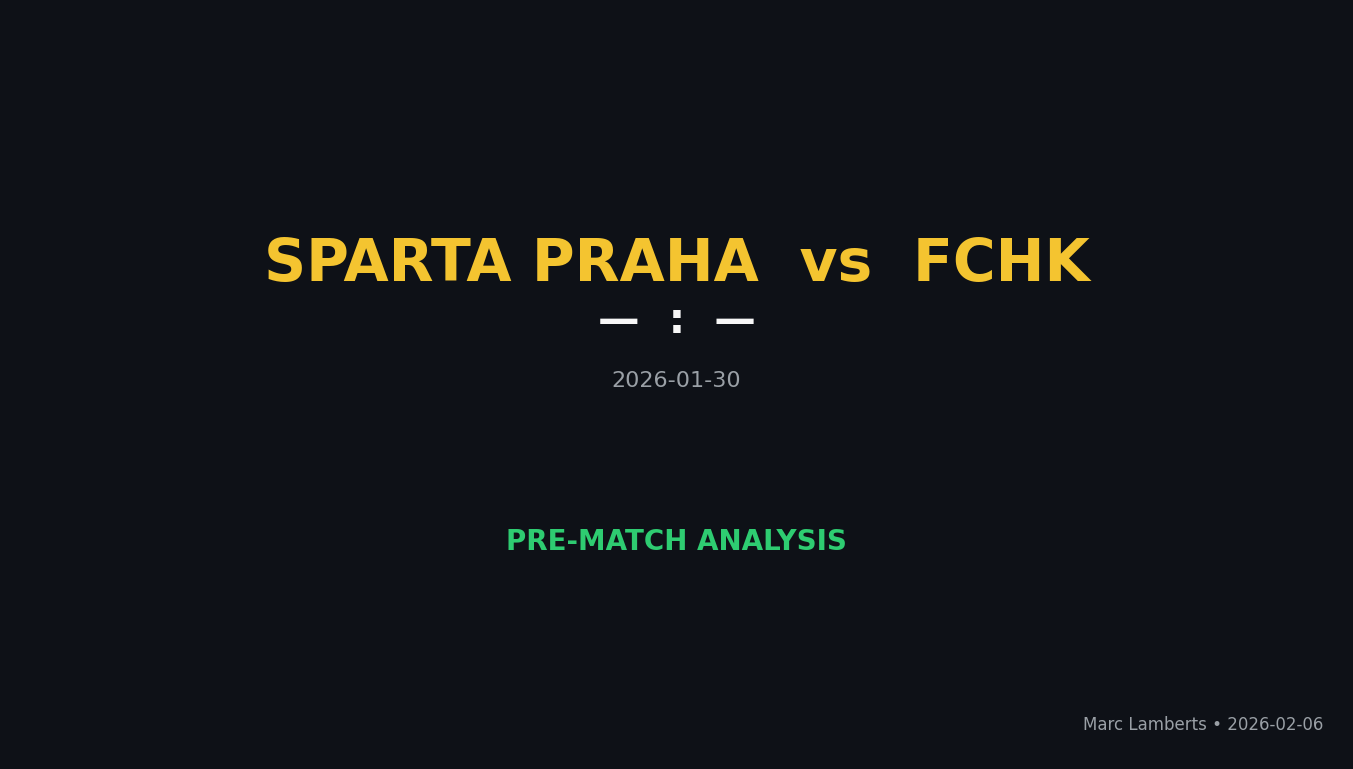

  ✅ Page 0 saved.

─── PAGE 1 : Formation & Positional ───


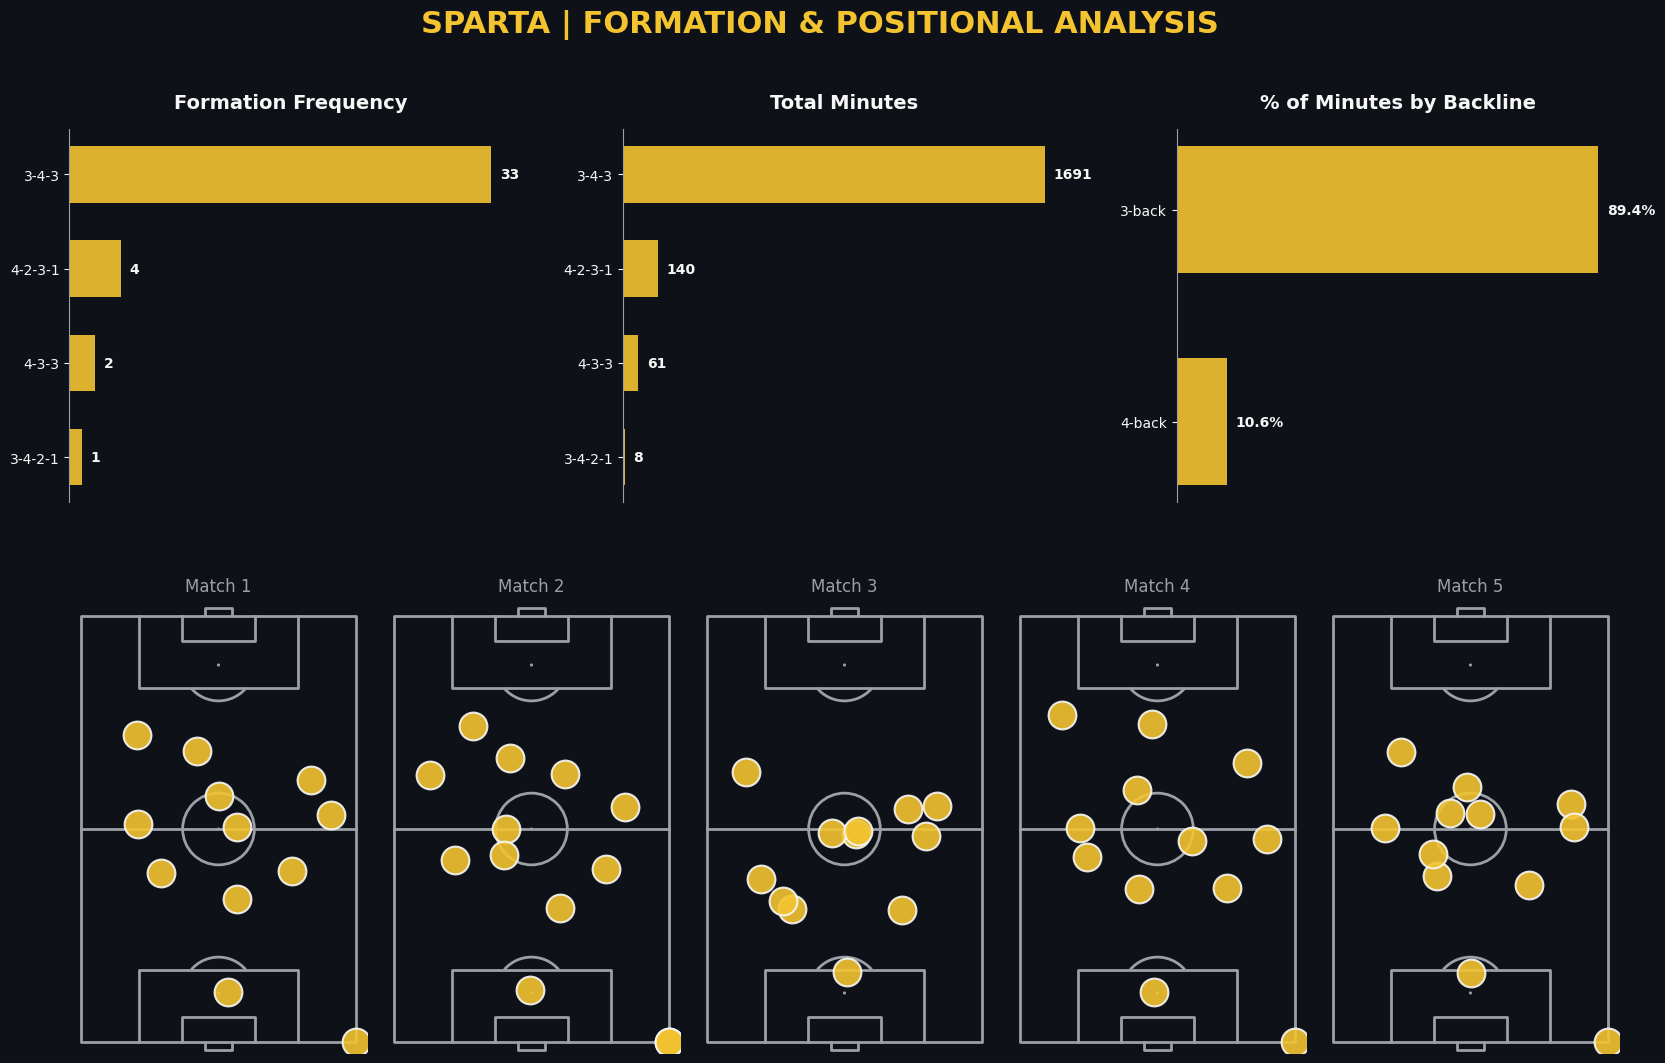

  ✅ Page 1 saved.

─── PAGE 2 : Passing Networks ───
  Pass network: 2025-12-06_SK Sigma Olomouc - AC Sparta Praha.json
  Pass network: 2025-12-14_AC Sparta Praha - FC Slovan Liberec.json
  Pass network: 2026-01-31_FK Dukla Praha - AC Sparta Praha.json
  ✅ Page 2 saved (3 networks).

─── PAGE 5 : Ball Progression ───


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8113/167730349.py:398: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats5 = prog5.groupby(["playerName","third"]).size().rename("count").reset_index()
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8113/167730349.py:401: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  locs5 = prog5.groupby(["playerName","third"])[["x","y"]].mean().reset_index()


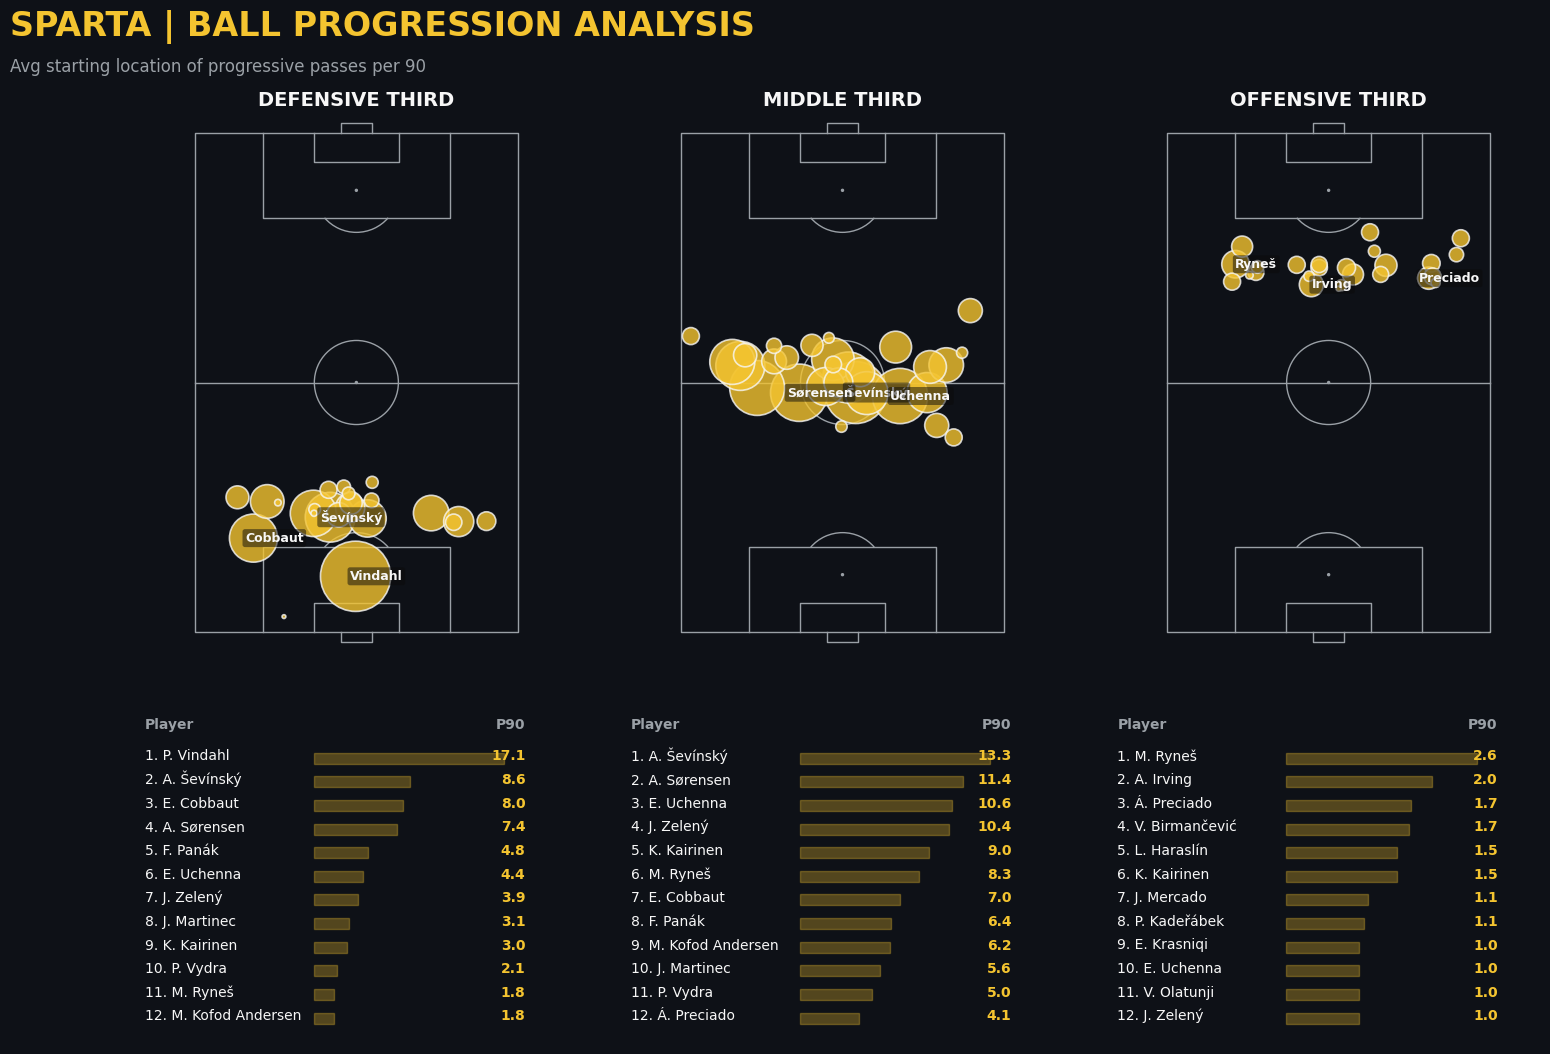

  ✅ Page 5 saved.

─── PAGE 6 : Line-Breaking ───


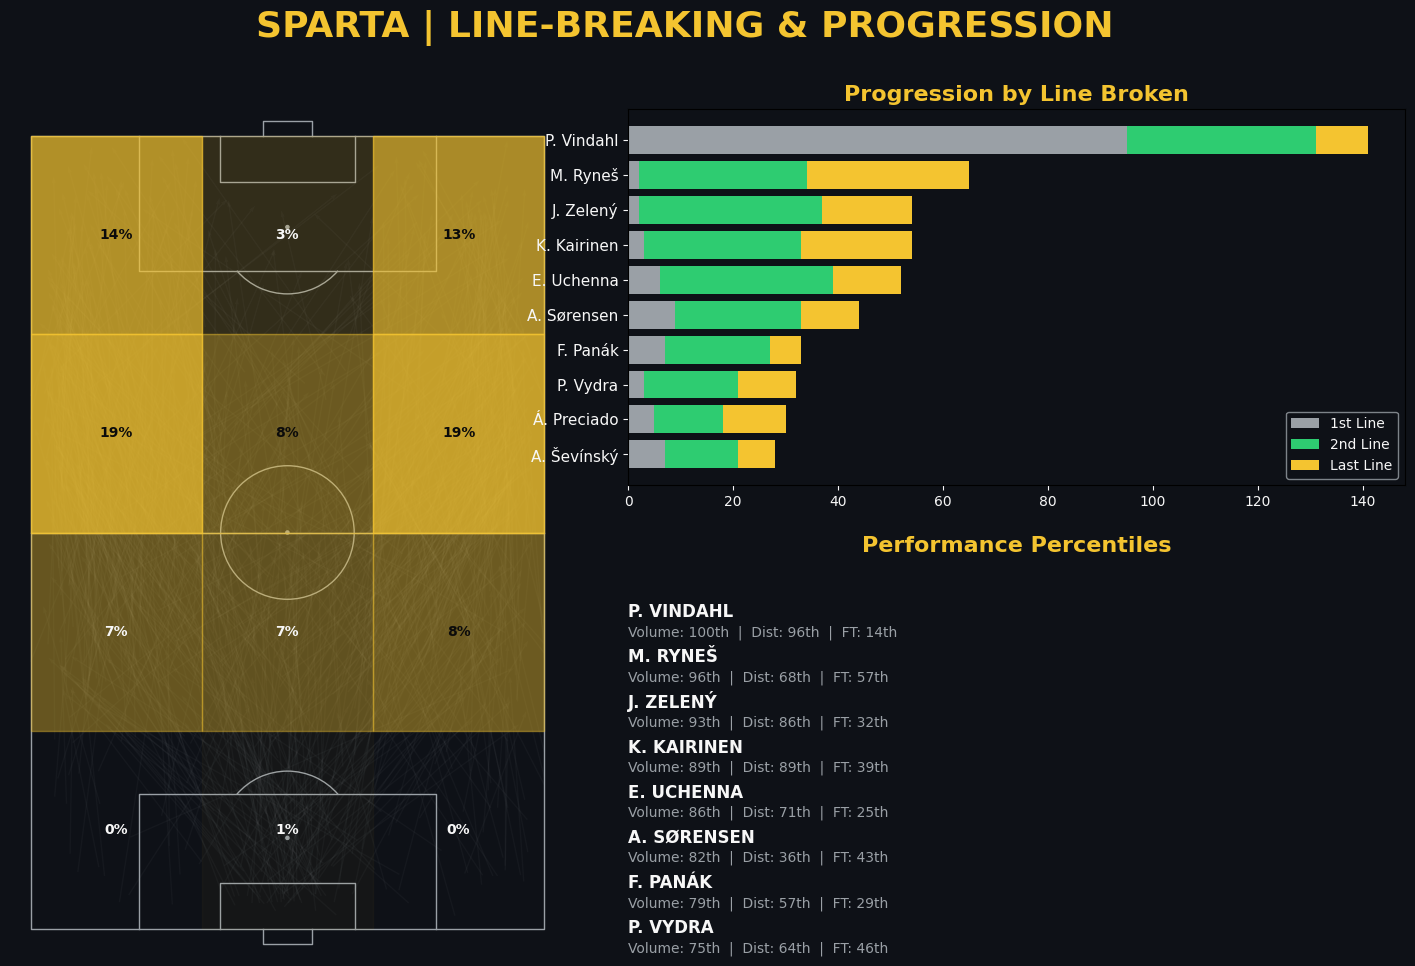

  ✅ Page 6 saved.

─── PAGE 7 : Possession vs Field Tilt ───


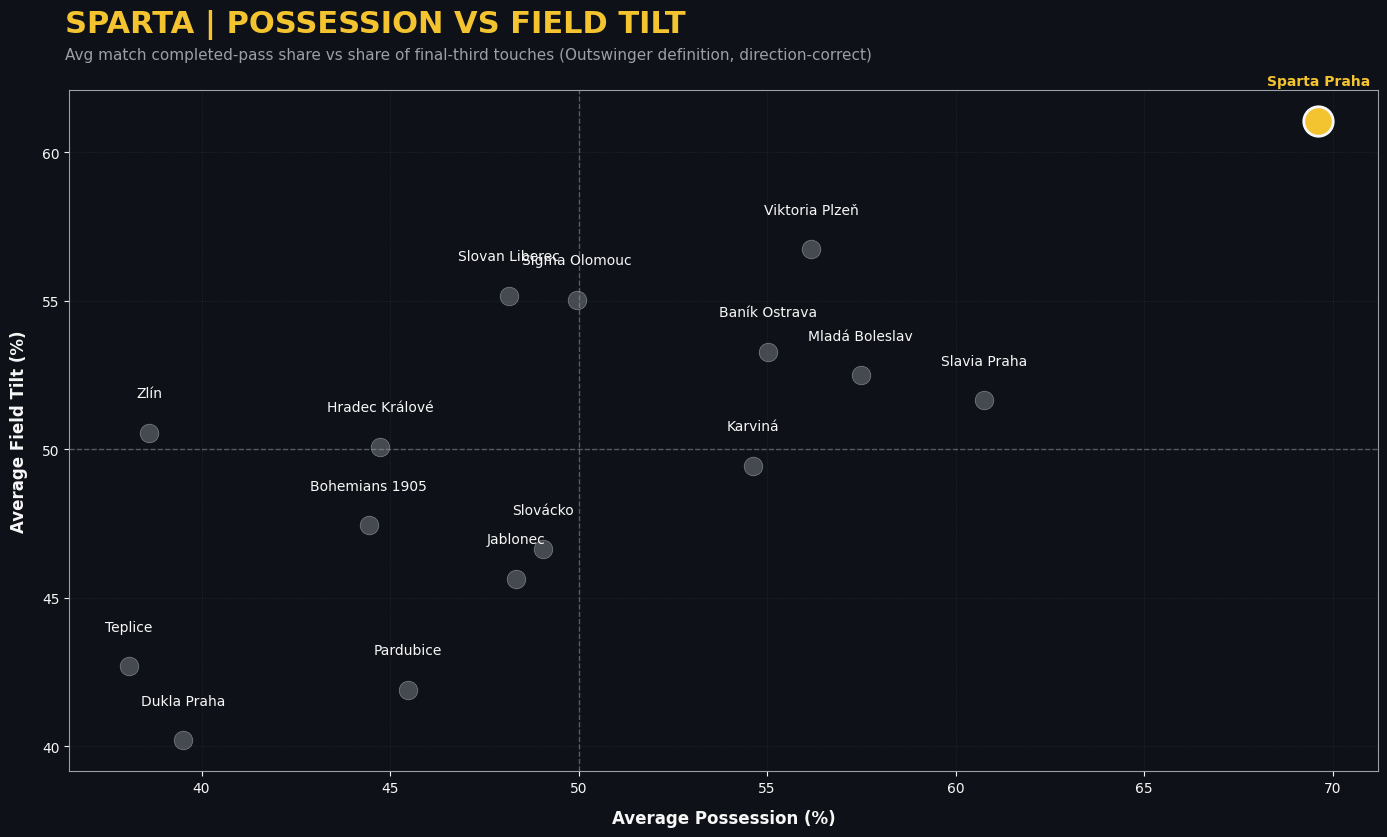

  ✅ Page 7 saved.

─── PAGE 8 : Progressive Pass Density ───


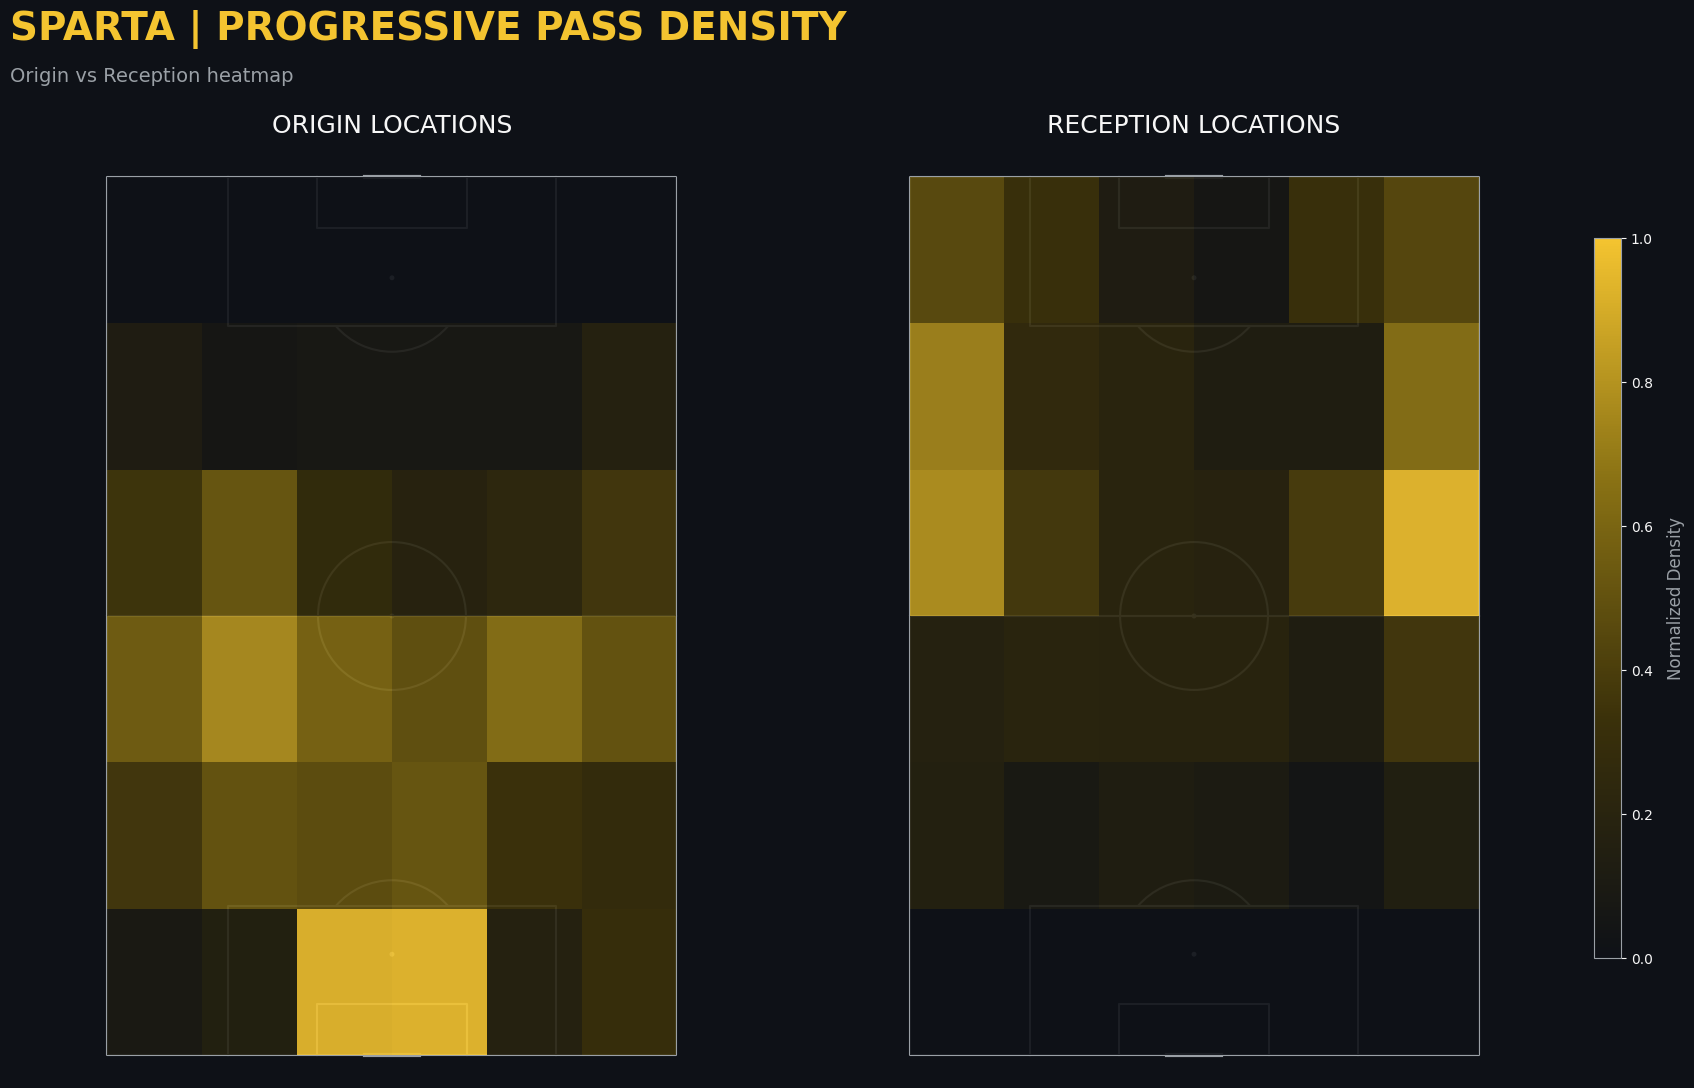

  ✅ Page 8 saved.

─── PAGE 9 : Switches of Play ───


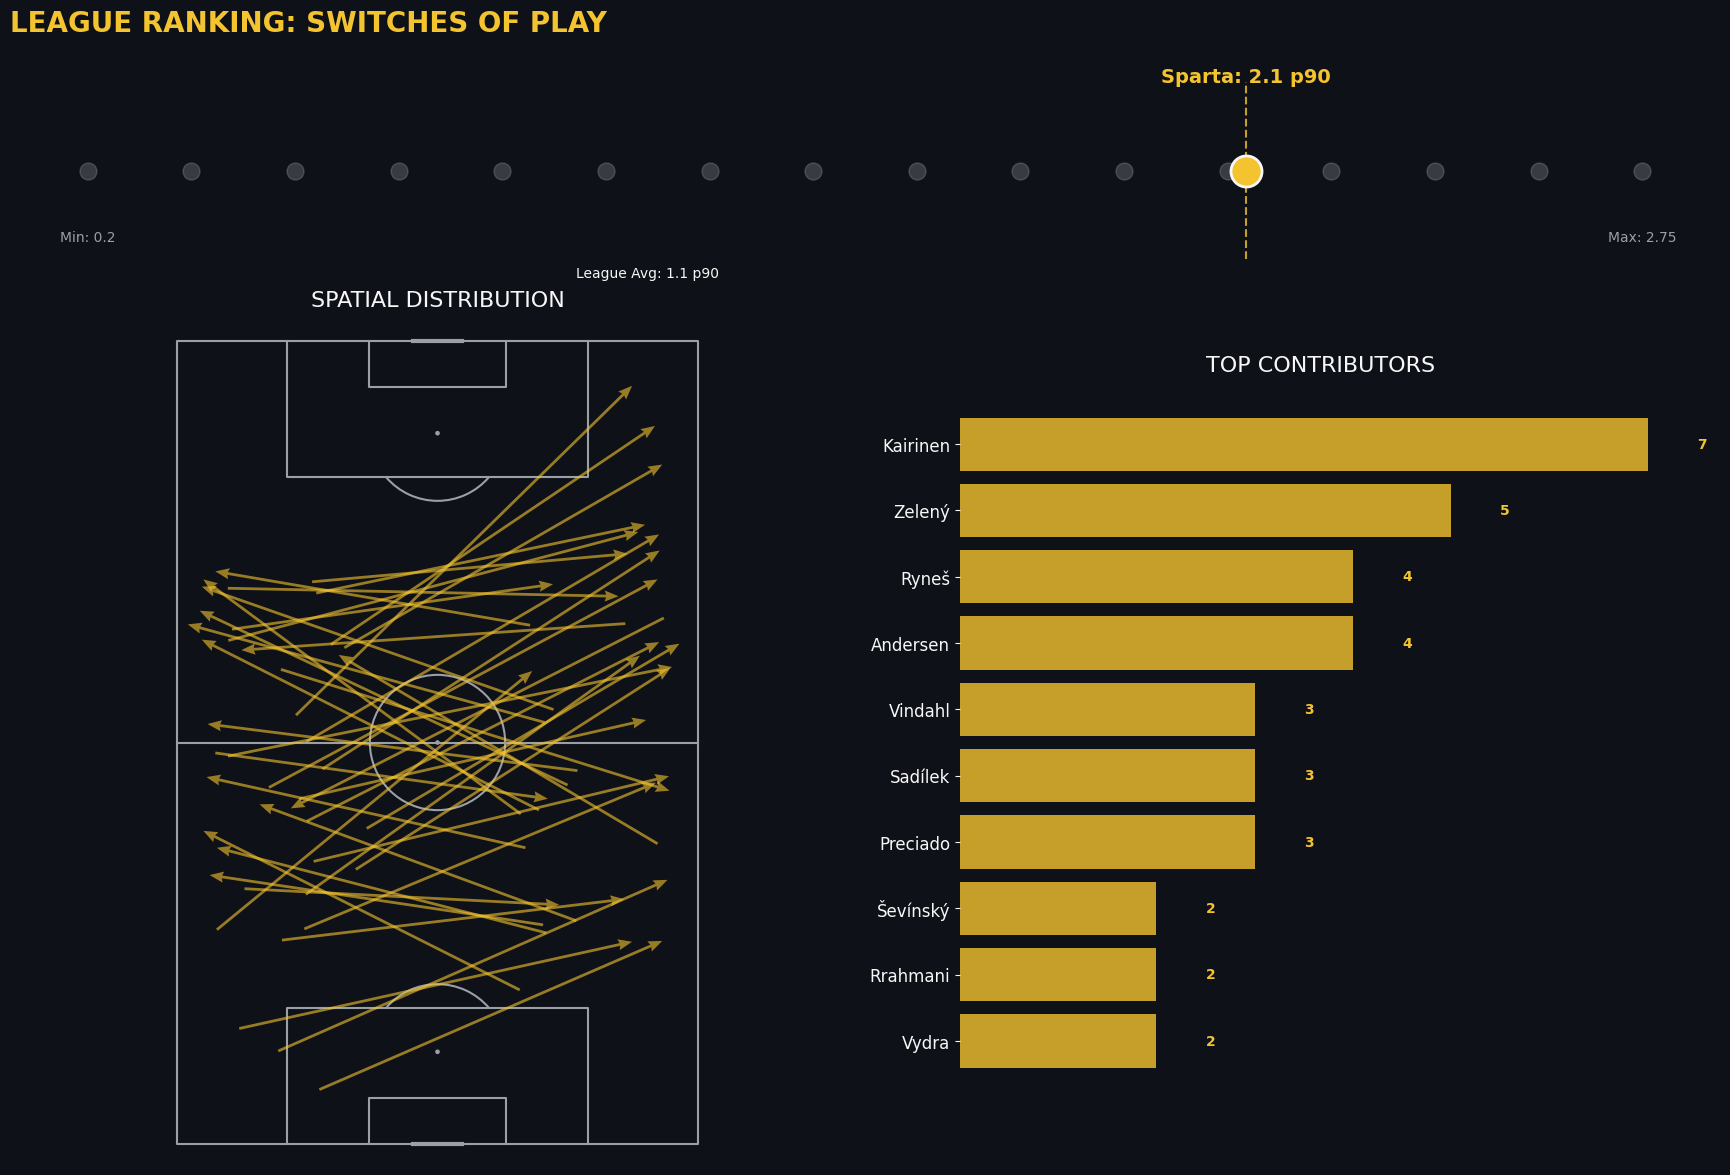

  ✅ Page 9 saved.

─── PAGE 10 : Creative Zone Analysis ───


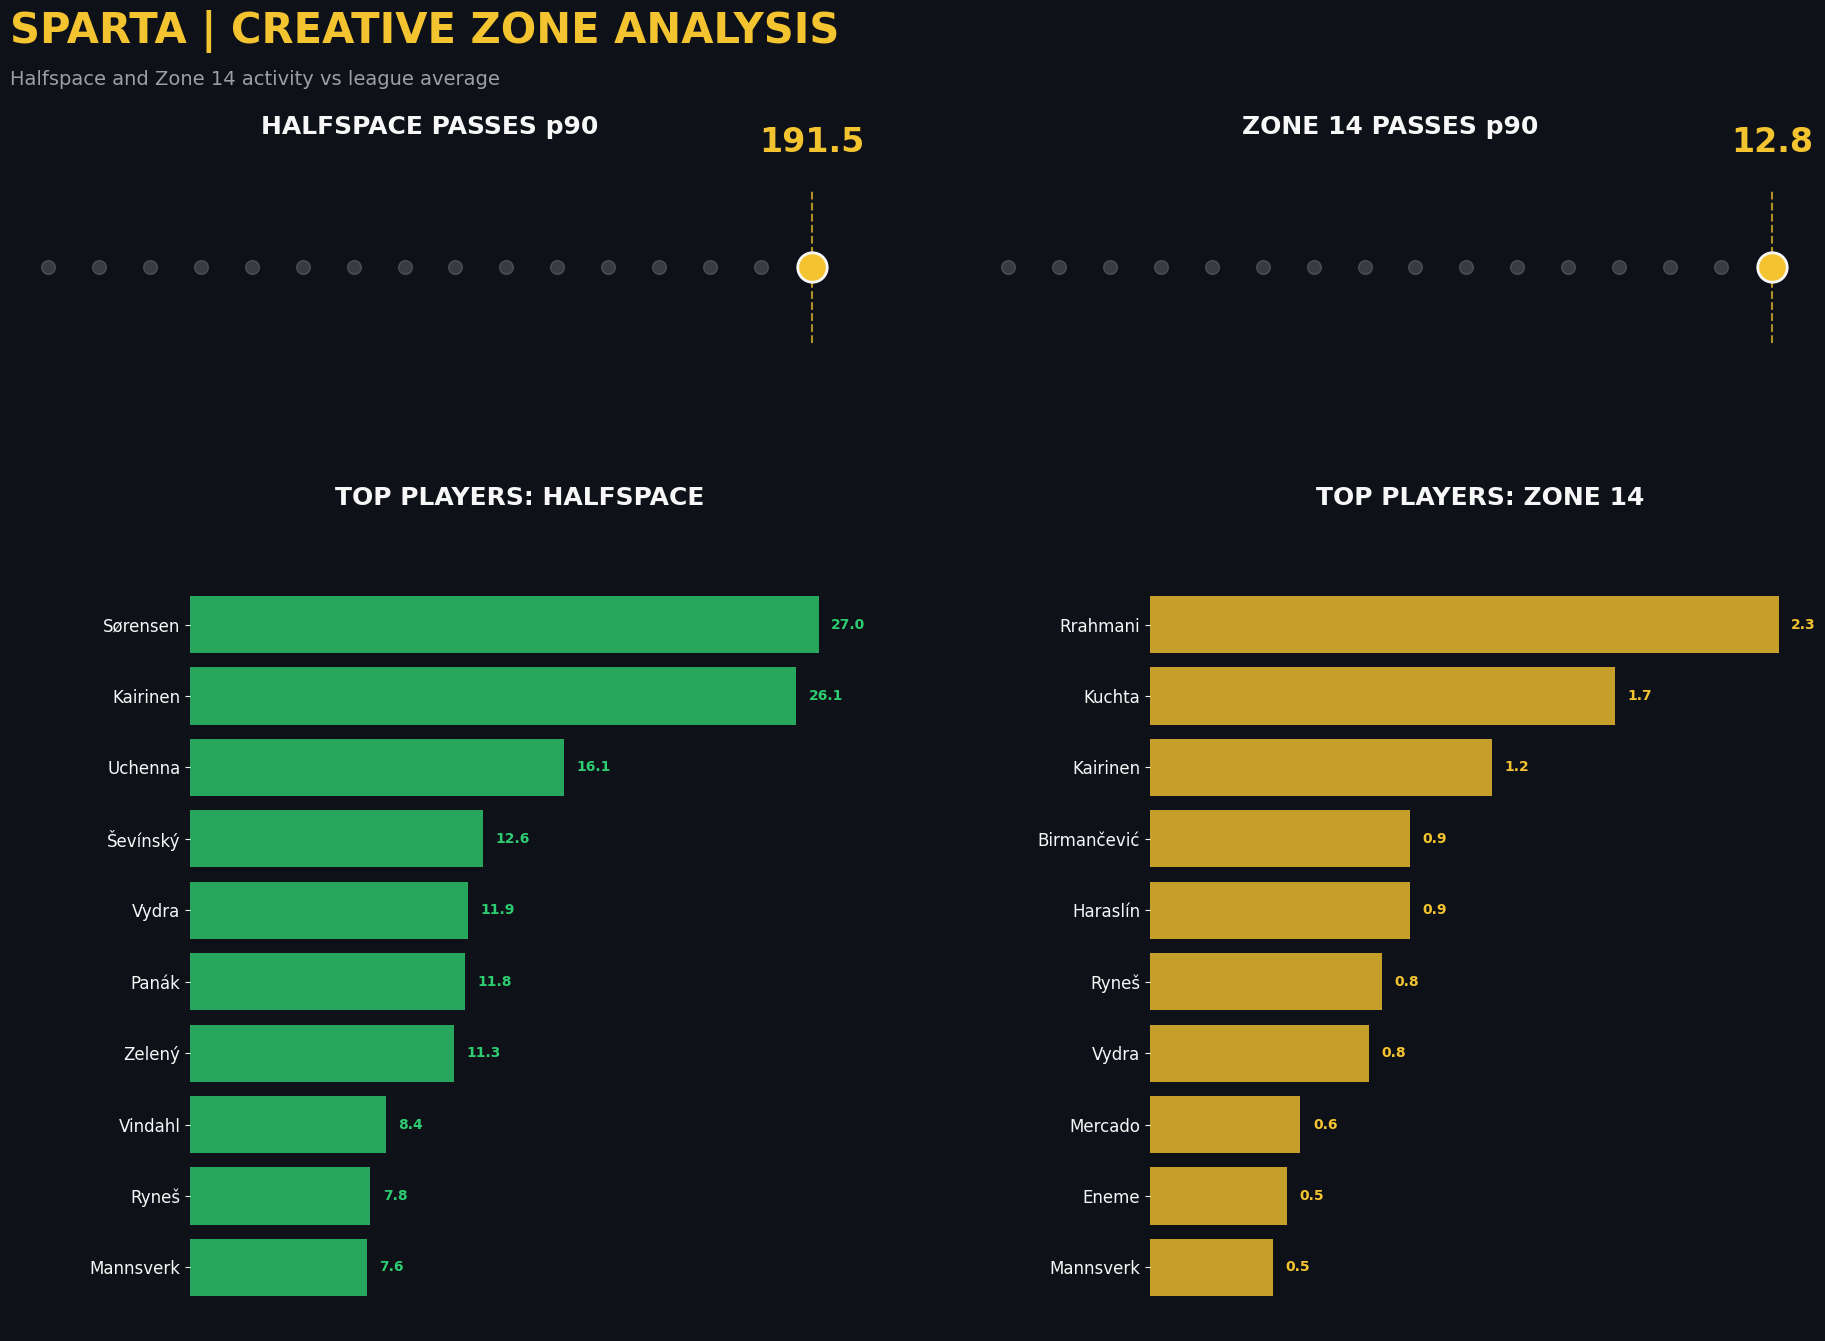

  ✅ Page 10 saved.

─── PAGE 11 : Cutback Reception Zones ───


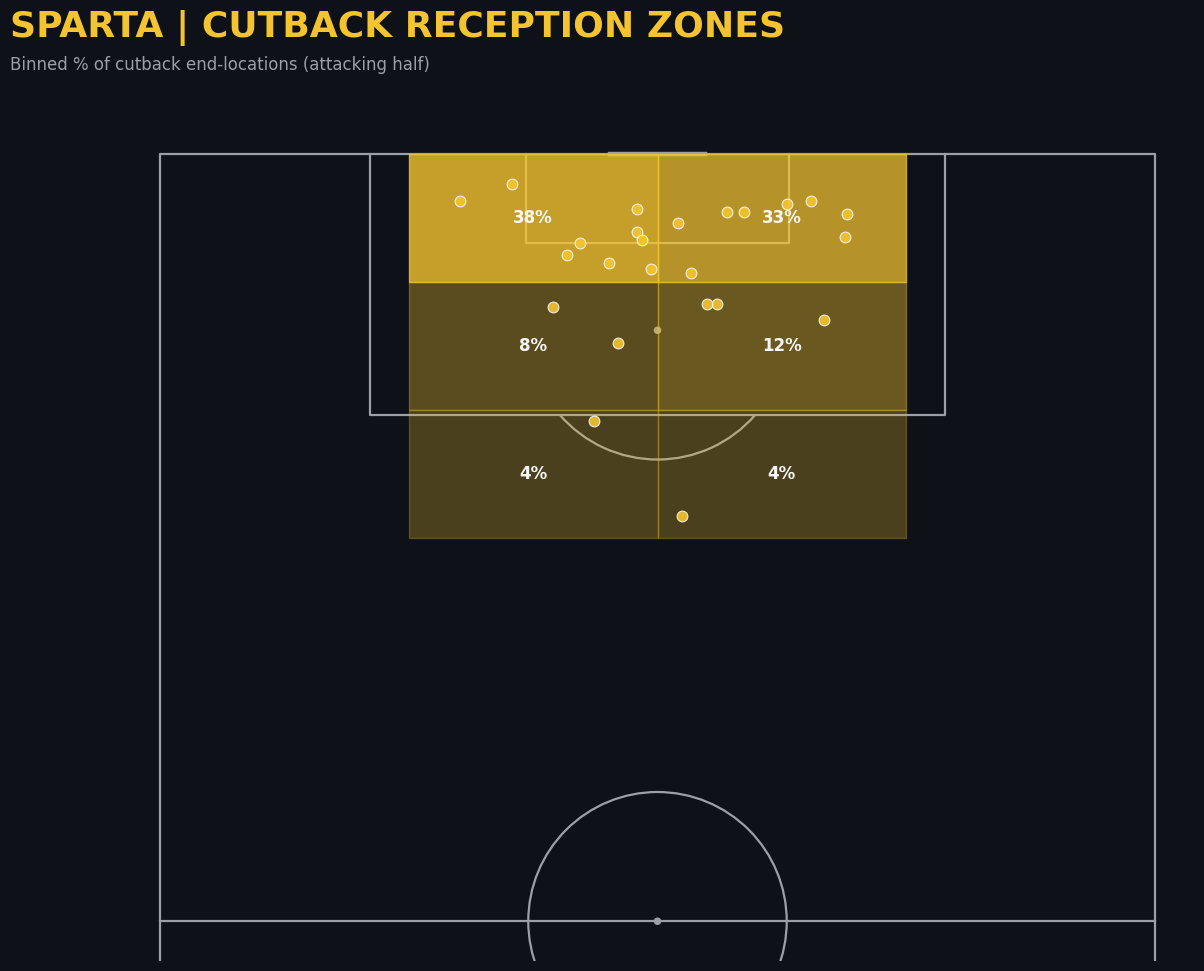

  ✅ Page 11 saved.

─── PAGE 12 : Long Ball Reception ───


In [ ]:

# ============================================================
# ██  TEAM INPUT  ██
# ============================================================
home_team       = input("Home team (title card):          ").strip()
away_team       = input("Away team (title card):          ").strip()
analyse_team    = input("Team to analyse (JSON Team col): ").strip()
xg_team_name    = input("Team to analyse xG (xgCSV TeamId col): ").strip()

# ============================================================
# IMPORTS
# ============================================================
import os, re, json, glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle, Circle
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import Pitch, VerticalPitch
from datetime import date

# ============================================================
# GLOBAL COLORS & RCPARAMS
# ============================================================
COLORS = {
    "yellow":     "#F4C430",
    "black":      "#0B0B0B",
    "white":      "#F7F7F7",
    "grey":       "#9AA0A6",
    "emerald":    "#2ECC71",
    "background": "#0e1117",
    "neutral_bar":"#2a2f3a",
}
BG   = COLORS["background"]
TXT  = COLORS["white"]
SUB  = COLORS["grey"]
ACC  = COLORS["yellow"]
EMR  = COLORS["emerald"]
NBAR = COLORS["neutral_bar"]

mpl.rcParams.update({
    "figure.facecolor": BG, "axes.facecolor": BG,
    "savefig.facecolor": BG, "savefig.transparent": False,
    "text.color": TXT, "axes.labelcolor": TXT,
    "xtick.color": TXT, "ytick.color": TXT,
    "font.family": "DejaVu Sans",
})

# ============================================================
# SHARED PATHS  (edit as needed)
# ============================================================
BADGE_DIR         = "/Users/user/Logo/"
JSON_FOLDER       = "/Users/user/XG/CZ/DONE"
TEAM_MAPPING_CSV  = "/Users/user/XG/CZ Matches.csv"
EVENT_MAP_CSV     = "/Users/user/opta-events.csv"
XG_CSV_FOLDER     = "/Users/user/XG/CZ/xgCSV"
OUTPUT_FOLDER     = "/Users/user/Documents/PROJECTS/Hradec Kralove/Opposition/Analysis/PRE MATCH"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ============================================================
# SHARED CONSTANTS
# ============================================================
QUAL_FORMATION   = 130
PROG_MIN_ADVANCE = 10.0
FINAL_THIRD_X    = 66.7
PROG_THRESHOLD   = 20.0
CC_QUALIFIER_ID  = 210

formation_lookup = {
    '2':'4-4-2','3':'4-1-2-1-2','4':'4-3-3','5':'4-5-1',
    '6':'4-4-1-1','7':'4-1-4-1','8':'4-2-3-1','9':'4-3-2-1',
    '10':'5-3-2','11':'5-4-1','12':'3-5-2','13':'3-4-3',
    '14':'3-1-3-1-2','15':'4-2-2-2','16':'3-5-1-1','17':'3-4-2-1',
    '18':'3-4-1-2','19':'3-1-4-2','20':'3-4-3','21':'4-1-3-2',
    '22':'4-2-4-0','23':'4-3-1-2',
}

# ============================================================
# SHARED HELPERS
# ============================================================
def safe_num(x):
    try:    return float(x)
    except: return np.nan

def normalize_name(s):
    if s is None: return ""
    return re.sub(r"[^A-Za-z0-9]", "", s.lower())

def extract_date(fn):
    m = re.match(r"(\d{4}-\d{2}-\d{2})_", fn)
    return m.group(1) if m else None

def add_badge(ax, img_path, xy_axes_frac, zoom):
    if not os.path.exists(img_path): return
    img = mpimg.imread(img_path)
    ax.add_artist(AnnotationBbox(
        OffsetImage(img, zoom=zoom), xy_axes_frac,
        xycoords="axes fraction", frameon=False
    ))

def load_json_events(json_path):
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except Exception as e:
        print(f"Could not read {json_path}: {e}")
        return pd.DataFrame()
    events = data.get("event", data.get("events", []))
    rows = []
    for e in events:
        row = {
            "eventId":     e.get("eventId"),
            "timeMin":     safe_num(e.get("timeMin")),
            "timeSec":     safe_num(e.get("timeSec")),
            "contestantId":str(e.get("contestantId")),
            "typeId":      e.get("typeId"),
            "outcome":     e.get("outcome"),
            "playerId":    str(e.get("playerId")),
            "playerName":  e.get("playerName"),
            "x":           safe_num(e.get("x")),
            "y":           safe_num(e.get("y")),
            "qualifier":   e.get("qualifier", []),
        }
        endx = endy = switch_flag = cutback_flag = is_cc = None
        for q in (row["qualifier"] or []):
            qid = q.get("qualifierId"); val = q.get("value")
            if qid == 140:  endx = float(val) if val is not None else None
            elif qid == 141: endy = float(val) if val is not None else None
            elif qid == 196: switch_flag = 1
            elif qid == 195: cutback_flag = 1
            elif qid == CC_QUALIFIER_ID: is_cc = 1
            elif qid == QUAL_FORMATION: row["Formation ID"] = str(val)
            elif qid == 1:  row["is_long_ball"] = 1
            elif qid == 124: row["is_goal_kick"] = 1
        row["endX"], row["endY"] = endx, endy
        row["switch"]     = switch_flag or 0
        row["is_cutback"] = cutback_flag or 0
        row["is_cc"]      = is_cc or 0
        row.setdefault("is_long_ball", 0)
        row.setdefault("is_goal_kick", 0)
        rows.append(row)
    return pd.DataFrame(rows)

def load_all_json_events(folder_path):
    all_dfs = []
    for fn in sorted(os.listdir(folder_path)):
        if fn.lower().endswith(".json"):
            df = load_json_events(os.path.join(folder_path, fn))
            if not df.empty:
                df["source_file"] = fn
                all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

def build_team_map(csv_path):
    """Returns a merged team-map from both contestant/0 and contestant/1 columns."""
    tdf = pd.read_csv(csv_path)
    maps = []
    for a, b in [
        ("matchInfo/contestant/0/id","matchInfo/contestant/0/name"),
        ("matchInfo/contestant/1/id","matchInfo/contestant/1/name"),
    ]:
        if a in tdf.columns and b in tdf.columns:
            t = tdf[[a,b]].dropna().copy()
            t.columns = ["contestantId","Team"]
            t["contestantId"] = t["contestantId"].astype(str)
            maps.append(t)
    return pd.concat(maps).drop_duplicates() if maps else pd.DataFrame()

def predict_receiver_by_proximity(match_df, i, team_id, endX, endY, lookahead=30):
    best_name, best_d2 = "Unknown", np.inf
    for j in range(i+1, min(i+1+lookahead, len(match_df))):
        nxt = match_df.iloc[j]
        if str(nxt.get("contestantId")) != str(team_id): continue
        pn = nxt.get("playerName")
        if not pn: continue
        sx = safe_num(nxt.get("x")); sy = safe_num(nxt.get("y"))
        if np.isnan(sx) or np.isnan(sy): continue
        d2 = (sx-endX)**2 + (sy-endY)**2
        if d2 < best_d2: best_d2, best_name = d2, pn
    return best_name

# ============================================================
# LOAD MASTER DATA ONCE
# ============================================================
print("Loading all JSON events …")
df_all = load_all_json_events(JSON_FOLDER)
team_map = build_team_map(TEAM_MAPPING_CSV)
df_all = df_all.merge(team_map, on="contestantId", how="left")
print(f"  → {len(df_all)} events loaded, {df_all['Team'].nunique()} teams mapped.")

# analyse_team drives every chart; logo / xG use their own variants.
TEAM     = analyse_team
TEAM_KEY = normalize_name(TEAM)

# ============================================================
# PAGE 0 – TITLE CARD
# ============================================================
print("\n─── PAGE 0 : Title Card ───")
match_date_str = "2026-01-30"
home_logo_zoom, away_logo_zoom = 0.25, 0.04

fig = plt.figure(figsize=(13.33, 7.5))
fig.patch.set_facecolor(BG)
ax = fig.add_axes([0,0,1,1]); ax.axis("off")

ax.text(0.5, 0.66, f"{home_team.upper()}  vs  {away_team.upper()}",
        ha="center", va="center", fontsize=42, fontweight="bold", color=ACC)

logo_y = 0.76
add_badge(ax, os.path.join(BADGE_DIR, f"{home_team}.png"), (0.30, logo_y), zoom=home_logo_zoom)
add_badge(ax, os.path.join(BADGE_DIR, f"{away_team}.png"), (0.70, logo_y), zoom=away_logo_zoom)

ax.text(0.5, 0.585, "—  :  —", ha="center", va="center", fontsize=30, fontweight="bold", color=TXT)
ax.text(0.5, 0.505, match_date_str, ha="center", va="center", fontsize=16, color=SUB)
ax.text(0.5, 0.29, "PRE-MATCH ANALYSIS", ha="center", va="center", fontsize=20, fontweight="bold", color=EMR)
ax.text(0.985, 0.035, f"Marc Lamberts • {date.today().strftime('%Y-%m-%d')}",
        ha="right", va="bottom", fontsize=12, color=SUB)

plt.savefig(os.path.join(OUTPUT_FOLDER, f"{home_team.upper().replace(' ','_')}_vs_{away_team.upper().replace(' ','_')}_Page0_TitleCard.png"),
            dpi=300, facecolor=BG, bbox_inches=None, transparent=False)
plt.show(); print("  ✅ Page 0 saved.")

# ============================================================
# PAGE 1 – FORMATION & POSITIONAL ANALYSIS
# ============================================================
print("\n─── PAGE 1 : Formation & Positional ───")
df_all["Formation Name"] = df_all["Formation ID"].map(formation_lookup)
team_full_df = df_all[df_all["Team"].str.contains(TEAM, case=False, na=False)].copy()

fc = team_full_df.dropna(subset=["Formation Name"]).sort_values(["source_file","timeMin"])
fc["next_time"] = fc.groupby("source_file")["timeMin"].shift(-1)
fc["duration_min"] = fc["next_time"] - fc["timeMin"]
fc["duration_min"] = fc["duration_min"].fillna(95 - fc["timeMin"])
fc.loc[fc["duration_min"]<=0,"duration_min"] = 1

fsummary = (fc.groupby("Formation Name")
            .agg(Uses=("Formation Name","count"), Total_Minutes=("duration_min","sum"))
            .reset_index())
if not fsummary.empty:
    tot = fsummary["Total_Minutes"].sum()
    fsummary["Pct_Time"] = (fsummary["Total_Minutes"]/tot*100).round(1)
    fsummary["Back Line"] = fsummary["Formation Name"].apply(lambda f: f"{f.split('-')[0]}-back")
    bl_sum = fsummary.groupby("Back Line")[["Total_Minutes"]].sum().reset_index()
    bl_sum["Pct_Time"] = (bl_sum["Total_Minutes"]/bl_sum["Total_Minutes"].sum()*100).round(1)
else:
    bl_sum = pd.DataFrame()

fig = plt.figure(figsize=(20,12), facecolor=BG)
gs  = fig.add_gridspec(2,1, height_ratios=[1.0,1.2], hspace=0.25)
gs_top = gs[0].subgridspec(1,3, wspace=0.25)

def barh_panel(ax, df, val_col, lbl_col, title, pct=False):
    ax.set_facecolor(BG)
    if df.empty:
        ax.text(0.5,0.5,"No Data",ha="center",color=SUB); ax.set_title(title); return
    dfp = df.sort_values(val_col, ascending=True)
    bars = ax.barh(dfp[lbl_col], dfp[val_col], color=ACC, alpha=0.9, height=0.6)
    mx = dfp[val_col].max()
    for b in bars:
        v = b.get_width()
        ax.text(v+(mx*0.02), b.get_y()+b.get_height()/2,
                f"{v:.1f}%" if pct else f"{int(v)}", va="center", fontweight="bold")
    ax.set_title(title, fontsize=14, fontweight="bold", pad=15)
    for s in ["top","right","bottom"]: ax.spines[s].set_visible(False)
    ax.spines["left"].set_color(SUB)
    ax.tick_params(axis="x", bottom=False, labelbottom=False)

barh_panel(fig.add_subplot(gs_top[0,0]), fsummary, "Uses",           "Formation Name","Formation Frequency")
barh_panel(fig.add_subplot(gs_top[0,1]), fsummary, "Total_Minutes",  "Formation Name","Total Minutes")
barh_panel(fig.add_subplot(gs_top[0,2]), bl_sum,   "Pct_Time",       "Back Line",     "% of Minutes by Backline", pct=True)

# avg positions – last 5 matches
all_jsons = sorted(
    [os.path.join(JSON_FOLDER,f) for f in os.listdir(JSON_FOLDER)
     if f.lower().endswith(".json") and TEAM_KEY in normalize_name(f)],
    key=os.path.getmtime)[-5:]

num_cols = len(all_jsons) or 1
gs_bot = gs[1].subgridspec(1, num_cols, wspace=0.05)
pitch = VerticalPitch(pitch_type="opta", pitch_color=BG, line_color=SUB, line_zorder=1, goal_type="box")

for i, path in enumerate(all_jsons):
    axp = fig.add_subplot(gs_bot[0,i]); pitch.draw(ax=axp)
    dfe = load_json_events(path).merge(team_map, on="contestantId", how="left")
    dft = dfe[dfe["Team"].str.contains(TEAM, case=False, na=False)].copy()
    if not dft.empty:
        first_sub = dft.loc[dft["typeId"]==19,"timeMin"].min()
        dft_pre = dft if pd.isna(first_sub) else dft[dft["timeMin"]<=first_sub]
        avg = dft_pre.groupby(["playerId","playerName"])[["x","y"]].mean().reset_index()
        pitch.scatter(avg["x"], avg["y"], ax=axp, s=400, color=ACC,
                      edgecolors=TXT, linewidth=1.5, zorder=3, alpha=0.9)
    axp.set_title(f"Match {i+1}", color=SUB, fontsize=12, pad=10)

fig.suptitle(f"{TEAM.upper()} | FORMATION & POSITIONAL ANALYSIS",
             fontsize=22, fontweight="bold", y=0.98, color=ACC)
plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page1_FormationPositional.png"),
            dpi=300, bbox_inches="tight", facecolor=BG)
plt.show(); print("  ✅ Page 1 saved.")

# ============================================================
# PAGE 2 – PASSING NETWORKS (last 3 matches)
# ============================================================
print("\n─── PAGE 2 : Passing Networks ───")
event_map = pd.read_csv(EVENT_MAP_CSV, encoding="ISO-8859-1")
event_map.columns = ["typeId","EventType","Description"]

matches_list = []
for fn in os.listdir(JSON_FOLDER):
    if fn.endswith(".json") and TEAM_KEY in normalize_name(fn):
        d = extract_date(fn)
        if d: matches_list.append((d, fn))
matches_list.sort()
last3 = matches_list[-3:]

for match_date, filename in last3:
    print(f"  Pass network: {filename}")
    with open(os.path.join(JSON_FOLDER, filename)) as f:
        raw = json.load(f)
    df = pd.DataFrame(raw["event"])
    df = df.merge(event_map[["typeId","EventType"]], on="typeId", how="left")
    df["t_sec"] = df["timeMin"]*60 + df["timeSec"]

    team_id = None
    for _, row in team_map.iterrows():
        if TEAM_KEY in normalize_name(row["Team"]):
            team_id = row["contestantId"]; break

    tdf = df[df["contestantId"]==team_id].copy()
    subs = tdf[tdf["typeId"].isin([18,19])]
    if not subs.empty: tdf = tdf[tdf["t_sec"]<subs["t_sec"].min()]

    passes = tdf[(tdf["typeId"]==1)&(tdf["outcome"]==1)].copy()
    passes["recipient"] = passes["playerName"].shift(-1)
    passes = passes.dropna(subset=["recipient"])

    nodes = passes.groupby("playerName").agg(x=("x","mean"), y=("y","mean"), touches=("playerName","count"))
    links = passes.groupby(["playerName","recipient"]).size().reset_index(name="count")
    links = links.merge(nodes, left_on="playerName", right_index=True)
    links = links.merge(nodes, left_on="recipient", right_index=True, suffixes=("","_end"))
    links = links[links["count"]>=3]

    fig, ax = plt.subplots(figsize=(16,11)); fig.patch.set_facecolor(BG)
    p = Pitch(pitch_type="opta", pitch_color=BG, line_color=SUB, linewidth=1.2, goal_type="box")
    p.draw(ax=ax)

    if not links.empty:
        mx = links["count"].max()
        for _, r in links.iterrows():
            lw = 1.5+(r["count"]/mx)*10; al = 0.4+(r["count"]/mx)*0.5
            p.lines(r["x"],r["y"],r["x_end"],r["y_end"], ax=ax, lw=lw, color=ACC, alpha=al, zorder=1)

    p.scatter(nodes["x"], nodes["y"], s=nodes["touches"]*25,
              color=ACC, edgecolors=TXT, linewidth=2, zorder=3, ax=ax)

    for name, r in nodes.iterrows():
        lbl = name.split(" ")[-1] if " " in name else name[:10]
        p.annotate(lbl, (r["x"],r["y"]), ax=ax, ha="center", va="center",
                   fontsize=10, color=COLORS["black"], fontweight="bold", zorder=5,
                   bbox=dict(facecolor=TXT, edgecolor=ACC, boxstyle="round,pad=0.3", alpha=0.9, linewidth=1.5))

    fig.text(0.5,0.94, f"{TEAM.upper()} — PASSING NETWORK", color=ACC, fontsize=24, fontweight="bold", ha="center")
    fig.text(0.5,0.91, f"Match Date: {match_date} | Cut at 1st Sub", color=SUB, fontsize=14, ha="center")

    for lp, pos in [(os.path.join(BADGE_DIR,f"{analyse_team}.png"),[0.03,0.88,0.1,0.1]),
                    (os.path.join(BADGE_DIR,"League.png"),[0.87,0.88,0.09,0.09])]:
        if os.path.exists(lp):
            ia = fig.add_axes(pos); ia.imshow(mpimg.imread(lp)); ia.axis("off")

    plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page2_PassNet_{match_date}.png"),
                dpi=300, bbox_inches="tight", facecolor=BG)
    plt.close()
print("  ✅ Page 2 saved (3 networks).")

# ============================================================
# PAGE 5 – BALL PROGRESSION
# ============================================================
print("\n─── PAGE 5 : Ball Progression ───")
tdf5 = df_all[df_all["Team"].str.contains(TEAM, case=False, na=False)].copy()
tdf5 = tdf5.dropna(subset=["x","endX"])
tdf5[["x","endX"]] = tdf5[["x","endX"]].astype(float)
minutes5 = (tdf5.groupby("playerName")["source_file"].nunique()*90).to_frame("mins")

passes5 = tdf5[(tdf5["typeId"]==1)&(tdf5["outcome"]==1)].dropna(subset=["endX"]).copy()

def is_progressive(row):
    try:
        sx, ex = float(row["x"]), float(row["endX"])
        if ex<=sx: return False
        return (ex-sx>=PROG_MIN_ADVANCE) or (sx<FINAL_THIRD_X<=ex)
    except: return False

passes5["is_prog"] = passes5.apply(is_progressive, axis=1)
prog5 = passes5[passes5["is_prog"]].copy()
prog5["third"] = pd.cut(prog5["x"], bins=[0,33.3,66.6,100], labels=["Defensive","Middle","Offensive"])

stats5 = prog5.groupby(["playerName","third"]).size().rename("count").reset_index()
stats5 = stats5.merge(minutes5, on="playerName")
stats5["per90"] = (stats5["count"]/(stats5["mins"]/90)).round(2)
locs5 = prog5.groupby(["playerName","third"])[["x","y"]].mean().reset_index()
stats5 = stats5.merge(locs5, on=["playerName","third"])

fig = plt.figure(figsize=(18,12), facecolor=BG)
gs = fig.add_gridspec(2,3, height_ratios=[2,1.2], hspace=0.2, wspace=0.15)
fig.text(0.05,0.95, f"{TEAM.upper()} | BALL PROGRESSION ANALYSIS", fontsize=24, fontweight="bold", color=ACC)
fig.text(0.05,0.92, "Avg starting location of progressive passes per 90", fontsize=12, color=SUB)

pitch_v = VerticalPitch(pitch_type="opta", pitch_color=BG, line_color=SUB, linewidth=1, goal_type="box")
thirds = ["Defensive","Middle","Offensive"]
for i, third in enumerate(thirds):
    axp = fig.add_subplot(gs[0,i]); pitch_v.draw(ax=axp)
    axp.set_title(f"{third.upper()} THIRD", color=TXT, fontsize=14, fontweight="bold", pad=10)
    sub = stats5[stats5["third"]==third].sort_values("per90", ascending=False)
    if not sub.empty:
        pitch_v.scatter(sub["x"], sub["y"], s=sub["per90"]*150, color=ACC,
                        edgecolors=TXT, linewidth=1.2, alpha=0.8, ax=axp, zorder=3)
        for _, row in sub.head(3).iterrows():
            ln = row["playerName"].split(" ")[-1]
            pitch_v.annotate(ln,(row["x"],row["y"]), ax=axp, color=TXT, fontsize=9,
                             ha="center", va="center", fontweight="bold",
                             xytext=(0,15), textcoords="offset points",
                             bbox=dict(facecolor=COLORS["black"], alpha=0.5, edgecolor="none", boxstyle="round,pad=0.2"))

    axt = fig.add_subplot(gs[1,i]); axt.axis("off")
    td = sub.head(12); yp = 0.9
    axt.text(0,1.0,"Player", fontweight="bold", color=SUB, transform=axt.transAxes)
    axt.text(0.9,1.0,"P90", fontweight="bold", color=SUB, transform=axt.transAxes, ha="right")
    for j,(_,row) in enumerate(td.iterrows()):
        if td["per90"].max()>0:
            bw = 0.45*(row["per90"]/td["per90"].max())
            axt.add_patch(Rectangle((0.4,yp-0.01),bw,0.035,color=ACC,alpha=0.3,transform=axt.transAxes))
        axt.text(0,yp,f"{j+1}. {row['playerName'][:18]}",fontsize=10,transform=axt.transAxes)
        axt.text(0.9,yp,f"{row['per90']:.1f}",fontsize=10,fontweight="bold",color=ACC,transform=axt.transAxes,ha="right")
        yp -= 0.075

plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page5_BallProgression.png"),
            dpi=300, bbox_inches="tight", facecolor=BG)
plt.show(); print("  ✅ Page 5 saved.")

# ============================================================
# PAGE 6 – LINE-BREAKING & PROGRESSION
# ============================================================
print("\n─── PAGE 6 : Line-Breaking ───")
tdf6 = df_all[df_all["Team"].str.contains(TEAM, case=False, na=False)].copy()
tdf6 = tdf6.dropna(subset=["x","y","endX","endY"])
tdf6[["x","y","endX","endY"]] = tdf6[["x","y","endX","endY"]].astype(float)

prog6 = tdf6[(tdf6["typeId"]==1)&(tdf6["outcome"]==1)].copy()
prog6["dx"] = prog6["endX"]-prog6["x"]
prog6 = prog6[prog6["dx"]>=PROG_THRESHOLD]

def classify_line(sx, ex):
    if sx is None or ex is None: return None
    if sx<75<=ex: return "Last"
    if sx<50<=ex: return "Second"
    if sx<25<=ex: return "First"
    return None

prog6["line_type"] = prog6.apply(lambda r: classify_line(r["x"],r["endX"]), axis=1)
lb6 = prog6.dropna(subset=["line_type"])
lc6 = lb6.groupby(["playerName","line_type"]).size().unstack(fill_value=0)
for c in ["First","Second","Last"]:
    if c not in lc6.columns: lc6[c]=0
lc6["Total"] = lc6.sum(axis=1)
top_br = lc6.sort_values("Total", ascending=False).head(10)

summary6 = prog6.groupby("playerName").agg(
    total_prog=("typeId","count"), avg_dx=("dx","mean"),
    final_third=("endX", lambda s: np.mean(s>=66))
)
summary6["pct_total"]      = summary6["total_prog"].rank(pct=True)*100
summary6["pct_avg_dx"]     = summary6["avg_dx"].rank(pct=True)*100
summary6["pct_final_third"]= summary6["final_third"].rank(pct=True)*100
pct_table6 = summary6.sort_values("total_prog", ascending=False).head(8)

fig = plt.figure(figsize=(18,11), facecolor=BG)
fig.suptitle(f"{TEAM.upper()} | LINE-BREAKING & PROGRESSION", fontsize=26, color=ACC, weight="bold", y=0.97)
gs = fig.add_gridspec(2,3, height_ratios=[1,1], width_ratios=[1.4,0.9,0.9], wspace=0.15, hspace=0.25)

ax_pitch = fig.add_subplot(gs[:,0])
pitch_v.draw(ax=ax_pitch)
pitch_v.arrows(prog6.x, prog6.y, prog6.endX, prog6.endY, ax=ax_pitch, width=1, color=SUB, alpha=0.05)

x_edges = np.linspace(0,100,5); y_edges = np.linspace(0,100,4)
H,_,_ = np.histogram2d(prog6.endX, prog6.endY, bins=[x_edges,y_edges])
pct6 = (H/H.sum()*100) if H.sum() else H
for i in range(4):
    for j in range(3):
        p = pct6[i,j]
        rect = Rectangle((y_edges[j],x_edges[i]), y_edges[j+1]-y_edges[j], x_edges[i+1]-x_edges[i],
                          color=ACC, alpha=min(p/pct6.max(),0.8) if pct6.max() else 0, zorder=1)
        ax_pitch.add_patch(rect)
        ax_pitch.text((y_edges[j]+y_edges[j+1])/2,(x_edges[i]+x_edges[i+1])/2,f"{p:.0f}%",
                      color=COLORS["black"] if p>(pct6.max()*0.4 if pct6.max()>0 else 1) else TXT,
                      ha="center", va="center", weight="bold")

ax_bars = fig.add_subplot(gs[0,1:])
players6 = top_br.index.tolist()[::-1]; yp6 = np.arange(len(players6))
ax_bars.barh(yp6, top_br.loc[players6,"First"], color=SUB, label="1st Line")
ax_bars.barh(yp6, top_br.loc[players6,"Second"], left=top_br.loc[players6,"First"], color=EMR, label="2nd Line")
ax_bars.barh(yp6, top_br.loc[players6,"Last"],
             left=top_br.loc[players6,"First"]+top_br.loc[players6,"Second"], color=ACC, label="Last Line")
ax_bars.set_yticks(yp6); ax_bars.set_yticklabels(players6, fontsize=11, color=TXT)
ax_bars.legend(loc="lower right", facecolor=BG, edgecolor=SUB, fontsize=10)
ax_bars.set_facecolor(BG)
ax_bars.set_title("Progression by Line Broken", fontsize=16, fontweight="bold", color=ACC)

ax_pct = fig.add_subplot(gs[1,1:]); ax_pct.axis("off")
ax_pct.set_title("Performance Percentiles", fontsize=16, fontweight="bold", color=ACC, pad=20)
yo = 0.9
for player, r in pct_table6.iterrows():
    ax_pct.text(0,yo,f"{player.upper()}",fontsize=12,fontweight="bold",color=TXT)
    ax_pct.text(0,yo-0.05,f"Volume: {r['pct_total']:.0f}th  |  Dist: {r['pct_avg_dx']:.0f}th  |  FT: {r['pct_final_third']:.0f}th",
                fontsize=10,color=SUB)
    yo -= 0.12

plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page6_LineBreaking.png"),
            dpi=300, bbox_inches="tight", facecolor=BG)
plt.show(); print("  ✅ Page 6 saved.")

# ============================================================
# PAGE 7 – POSSESSION VS FIELD TILT (FULL + FIXED)
#   - Possession proxy: completed passes share (default) OR touches share
#   - Field Tilt: Outswinger definition (share of final-third touches)
#   - Direction-correct using Opta qualifierId 127 when available
#   - Correct dedupe for Opta files where eventId repeats per team inside match
# ============================================================
print("\n─── PAGE 7 : Possession vs Field Tilt ───")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# SETTINGS
# ----------------------------
# Possession proxy options:
#   "passes_completed" (recommended)  -> share of completed passes in match
#   "touches"                         -> share of touch-like events in match
POSSESSION_METHOD = "passes_completed"

# Touch-like events (your list)
TOUCH_TYPES7 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,27,28,30,34,37,41,42,43,44,45,49,50,51,52,53,54,55,56,57,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77]

PASS_TYPE_ID = 1  # Opta pass
SHOT_TYPE_IDS = [13,14,15,16]  # not used for direction now (kept for compatibility)

MIN_MATCH_EVENTS = 200         # skip matches with poor coverage
MIN_MATCH_FT_TOUCHES = 10      # skip matches with too few final-third touches
MIN_MATCH_PASSES = 30          # skip matches with too few passes (for pass-based possession)

# ----------------------------
# MATCH KEY + DEDUPE (IMPORTANT)
# ----------------------------
# Prefer a real match id if you have it; otherwise source_file
MATCH_KEY = None
for c in ["matchId", "match_id", "fixture_id", "game_id", "MatchID"]:
    if c in df_all.columns:
        MATCH_KEY = c
        break
if MATCH_KEY is None:
    MATCH_KEY = "source_file"

# In your Opta JSON, the same match has duplicated eventId values for BOTH teams
# (same eventId appears once per contestantId). So dedupe must include contestantId.
dedupe_cols = [MATCH_KEY, "eventId"]
if "contestantId" in df_all.columns:
    dedupe_cols.append("contestantId")
elif "teamId" in df_all.columns:
    dedupe_cols.append("teamId")

df7 = df_all.drop_duplicates(subset=dedupe_cols).copy()

# Basic cleanup
df7 = df7[df7["Team"].notna()].copy()

# Coordinate scale detection for final third thresholds
xmax = float(df7["x"].dropna().max()) if "x" in df7.columns else 100.0
if xmax <= 105:          # 0..100 scale
    FINAL_THIRD_RIGHT = 66.7
    FINAL_THIRD_LEFT  = 33.3
else:                    # 0..120 scale
    FINAL_THIRD_RIGHT = 80.0
    FINAL_THIRD_LEFT  = 40.0

# ----------------------------
# DIRECTION FROM QUALIFIER 127 (Opta)
# ----------------------------
# In your feed there are events (often typeId==32) with qualifierId 127
# storing "Left to Right" / "Right to Left" per contestantId. :contentReference[oaicite:1]{index=1}
def get_team_direction_map_for_match(mdf: pd.DataFrame):
    """
    Returns dict: {contestantId(or teamId): "LTR" or "RTL"} for the match.
    Falls back to empty dict if qualifiers aren't present.
    """
    if "qualifier" not in mdf.columns:
        return {}

    id_col = "contestantId" if "contestantId" in mdf.columns else ("teamId" if "teamId" in mdf.columns else None)
    if id_col is None:
        return {}

    dmap = {}
    # Look through qualifier lists for qualifierId==127
    for _, r in mdf[[id_col, "qualifier"]].dropna(subset=[id_col]).iterrows():
        q = r["qualifier"]
        if not isinstance(q, (list, tuple)):
            continue
        for qq in q:
            if isinstance(qq, dict) and qq.get("qualifierId") == 127:
                val = str(qq.get("value", "")).lower()
                if "left to right" in val:
                    dmap[str(r[id_col])] = "LTR"
                elif "right to left" in val:
                    dmap[str(r[id_col])] = "RTL"
        # if we already have both teams, we can stop early
        if len(dmap) >= 2:
            break
    return dmap

def get_team_id_col(df: pd.DataFrame):
    if "contestantId" in df.columns:
        return "contestantId"
    if "teamId" in df.columns:
        return "teamId"
    return None

TEAM_ID_COL = get_team_id_col(df7)

# ----------------------------
# BUILD POSSESSION + FIELD TILT (MATCH-AVERAGED)
# ----------------------------
teams_all = sorted(df7["Team"].dropna().unique())
results7 = []

for team in teams_all:
    team_matches = df7.loc[df7["Team"] == team, MATCH_KEY].dropna().unique()

    poss_vals = []
    ft_vals = []

    for mk in team_matches:
        mdf = df7[df7[MATCH_KEY] == mk].copy()
        if len(mdf) < MIN_MATCH_EVENTS:
            continue

        # Identify opponent team name (match should have 2 teams)
        match_teams = mdf["Team"].dropna().unique().tolist()
        if team not in match_teams or len(match_teams) < 2:
            continue
        opp = [t for t in match_teams if t != team][0]

        # ------------------------
        # POSSESSION PROXY
        # ------------------------
        if POSSESSION_METHOD == "passes_completed":
            passes = mdf[mdf["typeId"] == PASS_TYPE_ID].copy()
            if len(passes) < MIN_MATCH_PASSES:
                continue
            # Opta typically uses outcome==1 for success
            if "outcome" in passes.columns:
                passes = passes[passes["outcome"] == 1]
            total = len(passes)
            if total > 0:
                poss_vals.append((passes["Team"] == team).sum() / total)
        else:
            touches = mdf[mdf["typeId"].isin(TOUCH_TYPES7)].copy()
            total = len(touches)
            if total > 0:
                poss_vals.append((touches["Team"] == team).sum() / total)

        # ------------------------
        # FIELD TILT (Outswinger)
        # share of final-third touches (team_ft / (team_ft + opp_ft))
        # direction-correct per team using qualifierId 127 if available
        # ------------------------
        touches_xy = mdf[mdf["typeId"].isin(TOUCH_TYPES7)].dropna(subset=["x"]).copy()
        if touches_xy.empty:
            continue

        # Direction map by team id
        dmap = get_team_direction_map_for_match(mdf)
        # Try resolve ids for the two teams
        team_dir = None
        opp_dir = None
        if TEAM_ID_COL is not None and dmap:
            # map Team -> first id seen for that Team in match
            team_id = str(mdf.loc[mdf["Team"] == team, TEAM_ID_COL].dropna().iloc[0]) if TEAM_ID_COL in mdf.columns and not mdf.loc[mdf["Team"] == team, TEAM_ID_COL].dropna().empty else None
            opp_id  = str(mdf.loc[mdf["Team"] == opp,  TEAM_ID_COL].dropna().iloc[0]) if TEAM_ID_COL in mdf.columns and not mdf.loc[mdf["Team"] == opp,  TEAM_ID_COL].dropna().empty else None
            if team_id is not None:
                team_dir = dmap.get(team_id)
            if opp_id is not None:
                opp_dir = dmap.get(opp_id)

        # If direction not found, skip match (better than wrong tilt)
        if team_dir is None or opp_dir is None:
            continue

        # For a team attacking LTR, opponent final third is RIGHT side (x >= FINAL_THIRD_RIGHT)
        # For a team attacking RTL, opponent final third is LEFT side (x <= FINAL_THIRD_LEFT)
        if team_dir == "LTR":
            team_ft = ((touches_xy["Team"] == team) & (touches_xy["x"] >= FINAL_THIRD_RIGHT)).sum()
        else:  # "RTL"
            team_ft = ((touches_xy["Team"] == team) & (touches_xy["x"] <= FINAL_THIRD_LEFT)).sum()

        if opp_dir == "LTR":
            opp_ft = ((touches_xy["Team"] == opp) & (touches_xy["x"] >= FINAL_THIRD_RIGHT)).sum()
        else:  # "RTL"
            opp_ft = ((touches_xy["Team"] == opp) & (touches_xy["x"] <= FINAL_THIRD_LEFT)).sum()

        total_ft = team_ft + opp_ft
        if total_ft >= MIN_MATCH_FT_TOUCHES:
            ft_vals.append(team_ft / total_ft)

    if poss_vals and ft_vals:
        results7.append({
            "team": team,
            "possession": float(np.mean(poss_vals) * 100),
            "field_tilt": float(np.mean(ft_vals) * 100),
        })

sum7 = pd.DataFrame(results7)
sum7["is_target"] = sum7["team"].str.contains(TEAM, case=False, na=False)

# ------------------------
# PLOT
# ------------------------
fig, ax = plt.subplots(figsize=(14,9), facecolor=BG)
ax.set_facecolor(BG)

title_team = TEAM.upper()
fig.text(0.05, 0.95, f"{title_team} | POSSESSION VS FIELD TILT", fontsize=22, fontweight="bold", color=ACC)
subtxt = "Avg match possession vs share of final-third touches (Outswinger definition, direction-correct)"
if POSSESSION_METHOD == "passes_completed":
    subtxt = "Avg match completed-pass share vs share of final-third touches (Outswinger definition, direction-correct)"
fig.text(0.05, 0.92, subtxt, fontsize=11, color=SUB)

ax.axhline(50, color=SUB, linestyle="--", linewidth=1, alpha=0.5)
ax.axvline(50, color=SUB, linestyle="--", linewidth=1, alpha=0.5)

ax.scatter(
    sum7.loc[~sum7["is_target"], "possession"],
    sum7.loc[~sum7["is_target"], "field_tilt"],
    s=180, alpha=0.4, color=SUB, edgecolor=TXT, linewidth=0.5
)

tgt7 = sum7[sum7["is_target"]]
if not tgt7.empty:
    ax.scatter(
        tgt7["possession"], tgt7["field_tilt"],
        s=450, color=ACC, edgecolor=TXT, linewidth=2, zorder=10
    )

for _, row in sum7.iterrows():
    ax.text(
        row["possession"], row["field_tilt"] + 1.2, row["team"],
        fontsize=10, ha="center",
        color=ACC if row["is_target"] else TXT,
        fontweight="bold" if row["is_target"] else "normal"
    )

ax.set_xlabel("Average Possession (%)", fontsize=12, fontweight="bold", color=TXT, labelpad=10)
ax.set_ylabel("Average Field Tilt (%)", fontsize=12, fontweight="bold", color=TXT, labelpad=10)

ax.tick_params(colors=TXT)
ax.grid(True, ls=":", lw=0.5, alpha=0.2, color=SUB)
for sp in ax.spines.values():
    sp.set_color(SUB)

plt.tight_layout(rect=[0, 0.05, 1, 0.92])
plt.savefig(
    os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page7_PossessionFieldTilt.png"),
    dpi=300, bbox_inches="tight", facecolor=BG
)
plt.show()
print("  ✅ Page 7 saved.")





# ============================================================
# PAGE 8 – PROGRESSIVE PASS DENSITY
# ============================================================
print("\n─── PAGE 8 : Progressive Pass Density ───")
yellow_cmap = LinearSegmentedColormap.from_list("prog_ycmap",[BG,"#3b310a","#8a7214",ACC])
tdf8 = df_all[df_all["Team"].str.contains(TEAM, case=False, na=False)].copy()
tdf8 = tdf8.dropna(subset=["x","y","endX","endY"])
tdf8[["x","y","endX","endY"]] = tdf8[["x","y","endX","endY"]].astype(float)
tdf8["dx"] = tdf8["endX"]-tdf8["x"]
prog8 = tdf8[(tdf8["typeId"]==1)&(tdf8["outcome"]==1)&(tdf8["dx"]>=PROG_THRESHOLD)].copy()

fig = plt.figure(figsize=(18,12), facecolor=BG)
fig.suptitle(f"{TEAM.upper()} | PROGRESSIVE PASS DENSITY", fontsize=28, weight="bold", color=ACC, x=0.05, ha="left", y=0.94)
fig.text(0.05,0.88,"Origin vs Reception heatmap",fontsize=14,color=SUB,ha="left")
gs = fig.add_gridspec(1,2, wspace=0.05, top=0.82, bottom=0.05, left=0.05, right=0.92)
pitch_v2 = VerticalPitch(pitch_type="opta", pitch_color=BG, line_color=SUB, linewidth=1.5)
bins8 = 6

ax1 = fig.add_subplot(gs[0,0]); pitch_v2.draw(ax=ax1)
ss = pitch_v2.bin_statistic(prog8.x, prog8.y, statistic="count", bins=(bins8,bins8), normalize=True)
pitch_v2.heatmap(ss, ax=ax1, cmap=yellow_cmap, alpha=0.9)
ax1.set_title("ORIGIN LOCATIONS", fontsize=18, color=TXT, pad=15)

ax2 = fig.add_subplot(gs[0,1]); pitch_v2.draw(ax=ax2)
es = pitch_v2.bin_statistic(prog8.endX, prog8.endY, statistic="count", bins=(bins8,bins8), normalize=True)
pitch_v2.heatmap(es, ax=ax2, cmap=yellow_cmap, alpha=0.9)
ax2.set_title("RECEPTION LOCATIONS", fontsize=18, color=TXT, pad=15)

cbar_ax = fig.add_axes([0.93,0.15,0.015,0.6])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=yellow_cmap), cax=cbar_ax)
cbar.outline.set_edgecolor(SUB)
cbar.set_label("Normalized Density", color=SUB, fontsize=12, labelpad=10)

plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page8_ProgPassDensity.png"),
            dpi=300, bbox_inches="tight", facecolor=BG)
plt.show(); print("  ✅ Page 8 saved.")

# ============================================================
# PAGE 9 – SWITCHES OF PLAY
# ============================================================
print("\n─── PAGE 9 : Switches of Play ───")
switches9 = df_all[(df_all["typeId"]==1)&(df_all["switch"]==1)&(df_all["outcome"]==1)].copy()
team_sw9 = switches9[switches9["Team"].str.contains(TEAM, case=False, na=False)]
top_players9 = team_sw9.groupby("playerName").size().sort_values(ascending=False).head(10)

# per-90 normalisation: total switches ÷ number of matches played
sw_count9  = switches9.groupby("Team").size()
match_count9 = df_all.groupby("Team")["source_file"].nunique()
tc9 = (sw_count9 / match_count9).dropna().sort_values()

# locate the target team with str.contains (index key may not be exact)
target_mask9 = tc9.index.to_series().str.contains(TEAM, case=False, na=False)
tv9 = float(tc9[target_mask9].iloc[0]) if target_mask9.any() else 0.0

vals9  = tc9.values
xvals9 = np.linspace(0, 1, len(vals9))
tx9    = np.interp(tv9, (vals9.min(), vals9.max()), (0, 1))
mv9    = vals9.mean()
mx9    = np.interp(mv9, (vals9.min(), vals9.max()), (0, 1))

fig = plt.figure(figsize=(19,13), facecolor=BG)
ax_top = fig.add_axes([0.05,0.74,0.90,0.15]); ax_top.set_facecolor(BG)
ax_top.set_xticks([]); ax_top.set_yticks([])
for sp in ax_top.spines.values(): sp.set_visible(False)
ax_top.scatter(xvals9, np.zeros_like(xvals9), s=150, color=SUB, alpha=0.3)
ax_top.scatter(tx9,0, s=500, color=ACC, edgecolor=TXT, lw=2, zorder=10)
ax_top.vlines(tx9,-0.5,0.5, color=ACC, linestyle="--", lw=1.5, alpha=0.8)
ax_top.text(xvals9[0],-0.4,f"Min: {vals9.min()}",ha="center",color=SUB)
ax_top.text(xvals9[-1],-0.4,f"Max: {vals9.max()}",ha="center",color=SUB)
ax_top.text(tx9,0.5,f"{TEAM}: {tv9:.1f} p90",ha="center",fontweight="bold",color=ACC,fontsize=14)
ax_top.text(mx9,-0.6,f"League Avg: {mv9:.1f} p90",ha="center",color=TXT,fontsize=10)
ax_top.set_title("LEAGUE RANKING: SWITCHES OF PLAY",fontsize=20,fontweight="bold",color=ACC,loc="left",pad=30)

ax_pitch9 = fig.add_axes([0.05,0.05,0.45,0.65])
pitch_v2.draw(ax=ax_pitch9)
pitch_v2.arrows(team_sw9.x, team_sw9.y, team_sw9.endX, team_sw9.endY,
                ax=ax_pitch9, color=ACC, width=2, headwidth=4, alpha=0.6)
ax_pitch9.set_title("SPATIAL DISTRIBUTION",fontsize=16,color=TXT,pad=10)

ax_bar9 = fig.add_axes([0.55,0.1,0.38,0.55]); ax_bar9.set_facecolor(BG)
p_names9 = [n.split(" ")[-1] for n in top_players9.index[::-1]]
ax_bar9.barh(np.arange(len(p_names9)), top_players9.values[::-1], color=ACC, alpha=0.8)
ax_bar9.set_yticks(np.arange(len(p_names9))); ax_bar9.set_yticklabels(p_names9,fontsize=12,color=TXT)
ax_bar9.set_xticks([])
for i,v in enumerate(top_players9.values[::-1]):
    ax_bar9.text(v+0.5,i,str(v),color=ACC,va="center",fontweight="bold")
for sp in ax_bar9.spines.values(): sp.set_visible(False)
ax_bar9.set_title("TOP CONTRIBUTORS",fontsize=16,color=TXT,pad=10)

plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page9_SwitchesOfPlay.png"),
            dpi=300, bbox_inches="tight", facecolor=BG)
plt.show(); print("  ✅ Page 9 saved.")

# ============================================================
# PAGE 10 – CREATIVE ZONE ANALYSIS
# ============================================================
print("\n─── PAGE 10 : Creative Zone Analysis ───")
passes10 = df_all[(df_all["typeId"]==1)&(df_all["outcome"]==1)].copy()
passes10 = passes10.dropna(subset=["x","y","endX","endY"])
passes10[["x","y","endX","endY"]] = passes10[["x","y","endX","endY"]].astype(float)

left_hs  = passes10[(passes10["y"]>=20)&(passes10["y"]<40)]
right_hs = passes10[(passes10["y"]>=60)&(passes10["y"]<=80)]
zone14   = passes10[(passes10["x"]>=70)&(passes10["y"]>=35)&(passes10["y"]<=65)]

mins_p_team = df_all.groupby("Team")["source_file"].nunique()*90
# locate target via str.contains (exact key match fails if name differs slightly)
target_mask10 = mins_p_team.index.to_series().str.contains(TEAM, case=False, na=False)
team_mins10   = float(mins_p_team[target_mask10].iloc[0]) if target_mask10.any() else 90.0

league_hs = ((left_hs.groupby("Team").size()+right_hs.groupby("Team").size())/(mins_p_team/90)).dropna().sort_values()
league_hz = (zone14.groupby("Team").size()/(mins_p_team/90)).dropna().sort_values()

t_mask_hs  = passes10["Team"].str.contains(TEAM, case=False, na=False)
t_mask_z14 = zone14["Team"].str.contains(TEAM, case=False, na=False)
team_hs_val = (len(left_hs[left_hs["Team"].str.contains(TEAM, case=False, na=False)])+
               len(right_hs[right_hs["Team"].str.contains(TEAM, case=False, na=False)]))/(team_mins10/90)
team_hz_val = len(zone14[t_mask_z14])/(team_mins10/90)

fig = plt.figure(figsize=(20,14), facecolor=BG)
fig.text(0.05,1.0,f"{TEAM.upper()} | CREATIVE ZONE ANALYSIS",fontsize=30,fontweight="bold",color=ACC)
fig.text(0.05,0.97,"Halfspace and Zone 14 activity vs league average",fontsize=14,color=SUB)

for i,(title,data,tv,pos) in enumerate([
    ("HALFSPACE PASSES p90", league_hs, team_hs_val, [0.05,0.78,0.42,0.12]),
    ("ZONE 14 PASSES p90",  league_hz, team_hz_val, [0.53,0.78,0.42,0.12])]):
    ax = fig.add_axes(pos); ax.set_facecolor(BG)
    ax.set_xticks([]); ax.set_yticks([])
    for sp in ax.spines.values(): sp.set_visible(False)
    xv = np.linspace(0,1,len(data))
    ax.scatter(xv, np.zeros_like(xv), s=100, color=SUB, alpha=0.3)
    t_x = np.interp(tv,(data.min(),data.max()),(0,1))
    ax.scatter(t_x,0, s=450, color=ACC, edgecolor=TXT, lw=2, zorder=10)
    ax.vlines(t_x,-0.6,0.6, color=ACC, ls="--", alpha=0.7)
    ax.set_title(title,fontsize=18,fontweight="bold",color=TXT,pad=35)
    ax.text(t_x,0.9,f"{tv:.1f}",color=ACC,fontsize=24,fontweight="bold",ha="center")

p_hs10 = passes10[passes10["Team"].str.contains(TEAM, case=False, na=False)]
p_hs10 = p_hs10[((p_hs10["y"]>=20)&(p_hs10["y"]<40))|((p_hs10["y"]>=60)&(p_hs10["y"]<=80))].groupby("playerName").size()
p_hs10 = (p_hs10/(team_mins10/90)).sort_values(ascending=False).head(10)
p_hz10 = zone14[zone14["Team"].str.contains(TEAM, case=False, na=False)].groupby("playerName").size()
p_hz10 = (p_hz10/(team_mins10/90)).sort_values(ascending=False).head(10)

for i,(title,data,color,pos) in enumerate([
    ("TOP PLAYERS: HALFSPACE",p_hs10,EMR,[0.14,0.08,0.33,0.55]),
    ("TOP PLAYERS: ZONE 14", p_hz10,ACC,[0.62,0.08,0.33,0.55])]):
    ax = fig.add_axes(pos); ax.set_facecolor(BG); ax.invert_yaxis()
    names = [n.split(" ")[-1] for n in data.index]
    ax.barh(names, data.values, color=color, alpha=0.8)
    for j,v in enumerate(data.values):
        ax.text(v+(data.max()*0.02),j,f"{v:.1f}",color=color,va="center",fontweight="bold")
    ax.set_title(title,fontsize=18,fontweight="bold",color=TXT,pad=40)
    ax.tick_params(axis="y",colors=TXT,labelsize=12)
    ax.set_xticks([])
    for sp in ax.spines.values(): sp.set_visible(False)

plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page10_CreativeZone.png"),
            dpi=300, bbox_inches="tight", facecolor=BG)
plt.show(); print("  ✅ Page 10 saved.")

# ============================================================
# PAGE 11 – CUTBACK RECEPTION ZONES
# ============================================================
print("\n─── PAGE 11 : Cutback Reception Zones ───")
cutbacks11 = df_all[
    (df_all["typeId"]==1)&(df_all["is_cutback"]==1)&
    (df_all["Team"].str.contains(TEAM, case=False, na=False))
].dropna(subset=["endX","endY"]).copy()

if not cutbacks11.empty:
    x_bins11 = np.linspace(50,100,7); y_bins11 = np.linspace(0,100,5)
    H11,xe11,ye11 = np.histogram2d(cutbacks11["endX"], cutbacks11["endY"], bins=[x_bins11,y_bins11])
    pct11 = (H11/H11.sum()*100) if H11.sum()>0 else H11

    fig = plt.figure(figsize=(14,11), facecolor=BG)
    ax = fig.add_subplot(111)
    pitch_half = VerticalPitch(pitch_type="opta", half=True, pitch_color=BG, line_color=SUB, linewidth=1.6)
    pitch_half.draw(ax=ax)
    fig.text(0.05,0.95,f"{TEAM.upper()} | CUTBACK RECEPTION ZONES",fontsize=26,fontweight="bold",color=ACC)
    fig.text(0.05,0.92,"Binned % of cutback end-locations (attacking half)",fontsize=12,color=SUB)

    mx11 = pct11.max() if pct11.max()>0 else 1
    for ix in range(len(x_bins11)-1):
        for iy in range(len(y_bins11)-1):
            val = pct11[ix,iy]
            if val<=0: continue
            rect = Rectangle((ye11[iy],xe11[ix]), ye11[iy+1]-ye11[iy], xe11[ix+1]-xe11[ix],
                              color=ACC, alpha=0.2+0.6*(val/mx11), zorder=2)
            ax.add_patch(rect)
            ax.text((ye11[iy]+ye11[iy+1])/2,(xe11[ix]+xe11[ix+1])/2,f"{val:.0f}%",
                    ha="center",va="center",fontsize=12,fontweight="bold",color=TXT,zorder=4)
    pitch_half.scatter(cutbacks11["endX"], cutbacks11["endY"], ax=ax, s=60,
                       color=ACC, edgecolors=TXT, linewidth=0.8, alpha=0.9, zorder=5)
    plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page11_CutbackZones.png"),
                dpi=300, bbox_inches="tight", facecolor=BG)
    plt.show()
else:
    print("  ⚠ No cutbacks found.")
print("  ✅ Page 11 saved.")

# ============================================================
# PAGE 12 – LONG BALL RECEPTION TARGETS
# ============================================================
print("\n─── PAGE 12 : Long Ball Reception ───")
long_balls12 = []
for fn, mdf in df_all.groupby("source_file"):
    mdf = mdf.sort_values("eventId").reset_index(drop=True)
    for i, e in mdf.iterrows():
        if e.get("typeId")!=1 or e.get("is_long_ball")!=1: continue
        ex, ey = e.get("endX"), e.get("endY")
        if ex is None or ey is None or np.isnan(ex) or np.isnan(ey): continue
        rcv = predict_receiver_by_proximity(mdf, i, e["contestantId"], ex, ey)
        long_balls12.append({"Team":e.get("Team"),"endX":ex,"endY":ey,"receiver":rcv,"source_file":fn})

df_lb12 = pd.DataFrame(long_balls12)
tdf_lb12 = df_lb12[df_lb12["Team"].str.contains(TEAM, case=False, na=False)].copy() if not df_lb12.empty else pd.DataFrame()

if not tdf_lb12.empty:
    rcv_avg12 = (tdf_lb12.groupby("receiver",dropna=False)
                 .agg(avgX=("endX","mean"),avgY=("endY","mean"),count=("receiver","size"))
                 .reset_index().sort_values("count",ascending=False))

    fig = plt.figure(figsize=(16,12), facecolor=BG)
    gs = fig.add_gridspec(2,1, height_ratios=[2.5,1], hspace=0.1)
    gs_top = gs[0].subgridspec(1,2, width_ratios=[2,1], wspace=0.05)
    ax_pitch12 = fig.add_subplot(gs_top[0,0]); ax_leg12 = fig.add_subplot(gs_top[0,1])

    p_h = Pitch(pitch_type="opta", pitch_color=BG, line_color=SUB, linewidth=1.5)
    p_h.draw(ax=ax_pitch12)

    for idx,row in rcv_avg12.iterrows():
        color = EMR if idx<3 else ACC
        size = 100+(row["count"]*15)
        p_h.scatter(row["avgX"],row["avgY"], s=size, color=color, edgecolors=TXT,
                    alpha=0.8, ax=ax_pitch12, zorder=10)
        if idx<5 and isinstance(row["receiver"],str) and row["receiver"]!="Unknown":
            p_h.annotate(row["receiver"].split(" ")[-1],(row["avgX"],row["avgY"]),
                         ax=ax_pitch12, color=TXT, fontsize=10, fontweight="bold",
                         va="bottom", xytext=(0,10), textcoords="offset points")

    ax_pitch12.set_title(f"{TEAM.upper()} | LONG BALL TARGETS",fontsize=22,fontweight="bold",color=ACC,pad=20)

    ax_leg12.axis("off")
    ax_leg12.text(0,0.95,"Key Receivers",fontsize=14,fontweight="bold",color=ACC)
    for i,(_,row) in enumerate(rcv_avg12.head(15).iterrows()):
        y = 0.88-(i*0.05)
        nm = str(row["receiver"]) if pd.notna(row["receiver"]) else "Unknown"
        ax_leg12.text(0,y,f"• {nm[:18]} ({int(row['count'])})",color=TXT,fontsize=11)

    ax_bot12 = fig.add_subplot(gs[1]); ax_bot12.set_facecolor(BG)
    top512 = rcv_avg12.head(5)
    ax_bot12.barh(top512["receiver"].astype(str), top512["count"], color=ACC, alpha=0.8)
    ax_bot12.invert_yaxis()
    ax_bot12.set_title("TOP 5 LONG BALL TARGETS",fontsize=16,fontweight="bold",color=SUB)
    ax_bot12.tick_params(axis="y",colors=TXT,labelsize=11); ax_bot12.set_xticks([])
    for sp in ax_bot12.spines.values(): sp.set_visible(False)
    plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page12_LongBallTargets.png"),
                dpi=300, bbox_inches="tight", facecolor=BG)
    plt.show()
else:
    print("  ⚠ No long balls found.")
print("  ✅ Page 12 saved.")

# ============================================================
# PAGE 13 – GOAL KICK TARGETS
# ============================================================
print("\n─── PAGE 13 : Goal Kick Targets ───")
gk_list13 = []
for fn, mdf in df_all.groupby("source_file"):
    mdf = mdf.sort_values("eventId").reset_index(drop=True)
    for i, e in mdf.iterrows():
        if e.get("typeId")!=1 or e.get("is_goal_kick")!=1: continue
        sx,sy = safe_num(e.get("x")), safe_num(e.get("y"))
        ex,ey = e.get("endX"), e.get("endY")
        if sx is None or sy is None or ex is None or ey is None: continue
        if np.isnan(sx) or np.isnan(sy) or np.isnan(ex) or np.isnan(ey): continue
        kicker = e.get("playerName")
        rcv = predict_receiver_by_proximity(mdf, i, e["contestantId"], ex, ey, lookahead=35)
        if rcv==kicker: rcv="Unknown"
        gk_list13.append({"contestantId":str(e["contestantId"]),"Team":e.get("Team"),
                          "x":sx,"y":sy,"endX":ex,"endY":ey,"receiver":rcv,"source_file":fn})

df_gk13 = pd.DataFrame(gk_list13)
tdf_gk13 = df_gk13[df_gk13["Team"].str.contains(TEAM, case=False, na=False)].copy() if not df_gk13.empty else pd.DataFrame()

if not tdf_gk13.empty:
    tdf_gk13["distance"] = np.sqrt((tdf_gk13["endX"]-tdf_gk13["x"])**2+(tdf_gk13["endY"]-tdf_gk13["y"])**2)
    tdf_gk13["type"] = np.where(tdf_gk13["distance"]<30,"Short","Long")

    rcv_sum13 = (tdf_gk13.groupby(["receiver","type"]).size().unstack(fill_value=0)
                 .rename(columns={"Short":"Short_Targets","Long":"Long_Targets"}).reset_index())
    top_short13 = rcv_sum13.sort_values("Short_Targets",ascending=False).head(5)
    top_long13  = rcv_sum13.sort_values("Long_Targets", ascending=False).head(5)

    fig = plt.figure(figsize=(16,10), facecolor=BG)
    gs = fig.add_gridspec(2,1, height_ratios=[2.5,1.2], hspace=0.08)
    gs_top = gs[0].subgridspec(1,2, width_ratios=[2.2,1], wspace=0.05)
    ax_p13 = fig.add_subplot(gs_top[0,0]); ax_l13 = fig.add_subplot(gs_top[0,1])

    p_gk = Pitch(pitch_type="opta", pitch_color=BG, line_color=SUB, linewidth=1.5)
    p_gk.draw(ax=ax_p13)

    rcvrs13 = [r for r in tdf_gk13["receiver"].dropna().unique() if r!="Unknown"][:30]
    n_rcv13 = max(1,len(rcvrs13))
    cmap13 = plt.cm.get_cmap("tab20",n_rcv13)
    rcv_colors13 = {n:cmap13(i) for i,n in enumerate(rcvrs13)}
    rcv_colors13["Unknown"] = (0.55,0.55,0.55,0.85)

    for rcv,color in rcv_colors13.items():
        sub = tdf_gk13[tdf_gk13["receiver"]==rcv]
        if sub.empty: continue
        p_gk.scatter(sub["endX"],sub["endY"], ax=ax_p13, s=95, color=color, alpha=0.88,
                     edgecolors=TXT, linewidth=0.6)

    ax_p13.set_title(f"{TEAM.upper()} | GOAL KICK END LOCATIONS",fontsize=22,fontweight="bold",color=ACC,pad=18)

    ax_l13.set_facecolor(BG); ax_l13.axis("off")
    ax_l13.text(0,1,"Receivers",fontsize=13,fontweight="bold",color=ACC,va="top")
    items13 = list(rcv_colors13.items())
    left_col13,right_col13 = items13[:15],items13[15:]
    ys13,step13 = 0.9,0.05
    for i,(rcv,color) in enumerate(left_col13):
        y = ys13-i*step13
        ax_l13.add_patch(Rectangle((0.02,y-0.015),0.03,0.03,transform=ax_l13.transAxes,color=color,alpha=0.95))
        ax_l13.text(0.07,y,str(rcv)[:22],fontsize=11,color=TXT,va="center")
    for i,(rcv,color) in enumerate(right_col13):
        y = ys13-i*step13
        ax_l13.add_patch(Rectangle((0.52,y-0.015),0.03,0.03,transform=ax_l13.transAxes,color=color,alpha=0.95))
        ax_l13.text(0.57,y,str(rcv)[:22],fontsize=11,color=TXT,va="center")

    gs_bot13 = gs[1].subgridspec(1,2, width_ratios=[1,1], wspace=0.25)
    ax_s13 = fig.add_subplot(gs_bot13[0,0]); ax_lg13 = fig.add_subplot(gs_bot13[0,1])
    for ax in [ax_s13,ax_lg13]:
        ax.set_facecolor(BG)
        for sp in ax.spines.values(): sp.set_visible(False)
        ax.tick_params(left=False,bottom=False,labelbottom=False,colors=TXT)
        ax.tick_params(axis="y",colors=TXT,labelsize=11)

    ax_s13.barh(top_short13["receiver"].astype(str),top_short13["Short_Targets"],color=EMR,alpha=0.9)
    ax_s13.invert_yaxis()
    ax_s13.set_title("TOP 5 SHORT (<30m)",fontsize=14,fontweight="bold",color=SUB,pad=10)
    for i,v in enumerate(top_short13["Short_Targets"].tolist()):
        ax_s13.text(v+0.15,i,str(int(v)),va="center",fontsize=11,color=TXT)

    ax_lg13.barh(top_long13["receiver"].astype(str),top_long13["Long_Targets"],color=ACC,alpha=0.9)
    ax_lg13.invert_yaxis()
    ax_lg13.set_title("TOP 5 LONG (≥30m)",fontsize=14,fontweight="bold",color=SUB,pad=10)
    for i,v in enumerate(top_long13["Long_Targets"].tolist()):
        ax_lg13.text(v+0.15,i,str(int(v)),va="center",fontsize=11,color=TXT)

    plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page13_GoalKickTargets.png"),
                dpi=600, bbox_inches="tight", facecolor=BG)
    plt.show()
else:
    print("  ⚠ No goal kicks found.")
print("  ✅ Page 13 saved.")

# ============================================================
# RANKED BAR HELPER (reused for Pages 14, 15, 16)
# ============================================================
def ranked_bar_chart(metric_series, title, subtitle, save_name, unit_suffix=""):
    ms = metric_series.sort_values(ascending=False)
    teams_r = ms.index.tolist(); vals_r = ms.values
    ranks_r = np.arange(1,len(teams_r)+1)
    lavg = ms.mean()
    # str.contains so highlighting works even if Team value != TEAM exactly
    is_target_r = [bool(re.search(re.escape(TEAM), t, re.IGNORECASE)) for t in teams_r]

    fig, ax = plt.subplots(figsize=(10,12), facecolor=BG); ax.set_facecolor(BG)
    y = np.arange(len(teams_r))
    colors_r = [ACC if hit else NBAR for hit in is_target_r]
    ax.barh(y, vals_r, color=colors_r, edgecolor="none", height=0.72)
    ax.invert_yaxis(); ax.set_yticks([]); ax.set_xticks([])
    for sp in ax.spines.values(): sp.set_visible(False)
    ax.set_xlim(0, vals_r.max()*1.18)
    ax.axvline(lavg, color=SUB, linestyle="--", linewidth=1.5, alpha=0.9)
    ax.text(lavg, len(teams_r)-0.2,"League Average",ha="center",va="bottom",fontsize=10,color=SUB)
    for i,(team,rank) in enumerate(zip(teams_r,ranks_r)):
        ax.text(0,y[i],f"#{rank}  {team}",ha="left",va="center",fontsize=11,color=TXT,
                fontweight="bold" if is_target_r[i] else "normal")
    for i,val in enumerate(vals_r):
        ax.text(val+vals_r.max()*0.012,y[i],f"{val:.1f}{unit_suffix}",ha="left",va="center",
                fontsize=11,color=ACC if is_target_r[i] else TXT,fontweight="bold")
    fig.text(0.05,0.93,title,fontsize=20,color=ACC,weight="bold")
    fig.text(0.05,0.90,subtitle,fontsize=11,color=SUB)
    plt.savefig(os.path.join(OUTPUT_FOLDER, save_name),dpi=300,bbox_inches="tight",facecolor=BG)
    plt.show()

# ============================================================
# PAGE 14 – MID-THIRD HALFSPACE RECEPTIONS
# ============================================================
print("\n─── PAGE 14 : Mid-Third HS Receptions ───")
passes_all = df_all[(df_all["typeId"]==1)&(df_all["outcome"]==1)].copy()
passes_all = passes_all.dropna(subset=["endX","endY"])
passes_all[["endX","endY"]] = passes_all[["endX","endY"]].astype(float)

mid_hs = passes_all[
    (passes_all["endX"]>=33.33)&(passes_all["endX"]<=66.67)&(
        ((passes_all["endY"]>=20)&(passes_all["endY"]<40))|
        ((passes_all["endY"]>=60)&(passes_all["endY"]<=80))
    )
]
mins_team = df_all.groupby("Team")["source_file"].nunique().mul(90.0)
mid_hs_metric = (mid_hs.groupby("Team").size()/(mins_team/90)).dropna()
mid_hs_metric = mid_hs_metric[mid_hs_metric>0]

ranked_bar_chart(mid_hs_metric,
                 "MIDDLE THIRD HALFSPACE RECEPTIONS",
                 "Receives in the middle-third halfspaces more often.",
                 f"{TEAM.upper().replace(' ','_')}_Page14_MidThirdHS.png")
print("  ✅ Page 14 saved.")

# ============================================================
# PAGE 15 – FINAL THIRD HALFSPACE RECEPTIONS
# ============================================================
print("\n─── PAGE 15 : Final-Third HS Receptions ───")
ft_hs = passes_all[
    (passes_all["endX"]>=66.67)&(passes_all["endX"]<=100)&(
        ((passes_all["endY"]>=20)&(passes_all["endY"]<40))|
        ((passes_all["endY"]>=60)&(passes_all["endY"]<=80))
    )
]
ft_hs_metric = (ft_hs.groupby("Team").size()/(mins_team/90)).dropna()
ft_hs_metric = ft_hs_metric[ft_hs_metric>0]

ranked_bar_chart(ft_hs_metric,
                 "FINAL THIRD HALFSPACE RECEPTIONS",
                 "Successful pass receptions in final-third halfspaces.",
                 f"{TEAM.upper().replace(' ','_')}_Page15_FinalThirdHS.png")
print("  ✅ Page 15 saved.")

# ============================================================
# PAGE 16 – TEAM VERTICALITY
# ============================================================
print("\n─── PAGE 16 : Team Verticality ───")
fwd_passes = passes_all.copy()
fwd_passes = fwd_passes.dropna(subset=["x","endX"])
fwd_passes[["x","endX"]] = fwd_passes[["x","endX"]].astype(float)
fwd_passes["dx"] = fwd_passes["endX"]-fwd_passes["x"]
fwd_passes = fwd_passes[fwd_passes["dx"]>0]

vert_dict = {}
for team in sorted(df_all["Team"].dropna().unique()):
    tm_matches = fwd_passes[fwd_passes["Team"]==team]["source_file"].unique()
    pm = []
    for m in tm_matches:
        mp = fwd_passes[(fwd_passes["Team"]==team)&(fwd_passes["source_file"]==m)]
        if len(mp)>0: pm.append(mp["dx"].mean())
    if pm: vert_dict[team] = np.mean(pm)

vert_metric = pd.Series(vert_dict).dropna()
ranked_bar_chart(vert_metric,
                 "TEAM VERTICALITY",
                 "Avg forward distance per completed forward pass.",
                 f"{TEAM.upper().replace(' ','_')}_Page16_Verticality.png",
                 unit_suffix=" m/pass")
print("  ✅ Page 16 saved.")

# ============================================================
# PAGE 17 – ATTACKING SEQUENCE INVOLVEMENTS (FIXED)
#   Fixes:
#   1) Use ONLY shot-ending sequences
#   2) "WHERE SHOT-ENDING SEQUENCES OCCUR" = FIRST TEAM ACTION IN ATTACKING HALF (x>=50)
#      (NOT the first action of the whole possession which often starts near own box)
#   3) Draw ONE line per sequence: start(att half) -> shot (no event-to-event chaining)
#   4) Heatmap built ONLY from those start points (matches your x=50..100 grid)
# ============================================================
print("\n─── PAGE 17 : Attacking Sequence Inv. ───")

SHOT_TYPE_IDS = [13,14,15,16]
MIN_MINUTES = 180
TOP_N = 15
ATTACK_X_MIN = 50  # attacking-half threshold in your 0..100 pitch scale

team_mask17 = df_all["Team"].str.contains(TEAM, case=False, na=False)
tdf17 = df_all[team_mask17].copy()

shots17   = tdf17[tdf17["typeId"].isin(SHOT_TYPE_IDS)]
chances17 = tdf17[(tdf17["typeId"]==1) & (tdf17["is_cc"]==1)]
mins17    = (tdf17.groupby("playerName")["source_file"].nunique().mul(90.0)).rename("minutes")

# Sort and dedupe per match (eventId can repeat across files)
df_sorted17 = (
    df_all
    .drop_duplicates(subset=["source_file", "eventId"])
    .sort_values(["source_file","eventId"])
    .reset_index(drop=True)
)

# Optional sanity clamp to prevent bad coords creating corner artifacts
df_sorted17 = df_sorted17[
    df_sorted17["x"].between(0, 100, inclusive="both") &
    df_sorted17["y"].between(0, 100, inclusive="both")
].copy()

player_seq17 = {}
seq_start_xy17 = []      # ONLY start points used for heatmap
seq_lines17 = []         # ONLY start->shot lines

for mn, mdf in df_sorted17.groupby("source_file"):
    if not (mdf["Team"].str.contains(TEAM, case=False, na=False)).any():
        continue

    mdf = mdf.reset_index(drop=True)

    # Your original possession/segment proxy: team-change runs
    ts = mdf["Team"].astype(str).values
    tc = np.zeros(len(mdf), dtype=int)
    tc[1:] = (ts[1:] != ts[:-1]).astype(int)
    mdf["pid"] = tc.cumsum()

    # TEAM shots in this match
    ms17 = mdf[
        (mdf["Team"].str.contains(TEAM, case=False, na=False)) &
        (mdf["typeId"].isin(SHOT_TYPE_IDS))
    ]
    if ms17.empty:
        continue

    for _, shot in ms17.iterrows():
        # segment = all events in same pid up to and including the shot
        seg = mdf[(mdf["pid"] == shot["pid"]) & (mdf["eventId"] <= shot["eventId"])]

        # TEAM-only events within the segment
        seg_t = seg[seg["Team"].str.contains(TEAM, case=False, na=False)]
        if seg_t.empty:
            continue

        # Sequence involvement counts (unchanged): each player appearing in segment gets +1
        for p in seg_t["playerName"].dropna().unique():
            player_seq17[p] = player_seq17.get(p, 0) + 1

        # ---- FIX: "WHERE sequences occur" = first TEAM event in attacking half
        seg_att = seg_t[seg_t["x"].notna() & seg_t["y"].notna() & (seg_t["x"] >= ATTACK_X_MIN)]
        if seg_att.empty:
            continue  # sequence never reaches attacking half, exclude from this viz

        start_ev = seg_att.iloc[0]
        sx, sy = float(start_ev["x"]), float(start_ev["y"])
        seq_start_xy17.append((sx, sy))

        # ---- One line per sequence: start(att half) -> shot
        if pd.notna(shot["x"]) and pd.notna(shot["y"]):
            ex, ey = float(shot["x"]), float(shot["y"])
            # (Optional) ensure shot is also on-pitch
            if 0 <= ex <= 100 and 0 <= ey <= 100:
                seq_lines17.append((sx, sy, ex, ey))


# Build player stats table
seq_inv17 = pd.Series(player_seq17, name="seq_inv")

stats17 = pd.DataFrame(index=mins17.index)
stats17["minutes"] = mins17
stats17 = stats17.join(shots17.groupby("playerName").size().rename("shots"))
stats17 = stats17.join(chances17.groupby("playerName").size().rename("cc"))
stats17 = stats17.join(seq_inv17).fillna(0)

stats17 = stats17[stats17["minutes"] >= MIN_MINUTES]
fac17 = stats17["minutes"] / 90.0
stats17["shots_p90"] = stats17["shots"] / fac17
stats17["cc_p90"]    = stats17["cc"] / fac17
stats17["seq_p90"]   = stats17["seq_inv"] / fac17
stats17 = stats17.replace([np.inf, -np.inf], 0)

stats17["asi_p90"] = stats17["shots_p90"] + stats17["cc_p90"] + stats17["seq_p90"]
stats17_sorted = stats17.sort_values("asi_p90", ascending=False).head(TOP_N)

# Heatmap bins: your original (attacking half)
seq_xy_arr = np.array(seq_start_xy17) if seq_start_xy17 else np.empty((0,2))

x_e17 = np.linspace(50, 100, 4)   # attacking half bands
y_e17 = np.linspace(0, 100, 4)    # width bands

H17, _, _ = np.histogram2d(
    seq_xy_arr[:,0] if len(seq_xy_arr) else [],
    seq_xy_arr[:,1] if len(seq_xy_arr) else [],
    bins=[x_e17, y_e17]
)

pct17 = (H17 / H17.sum() * 100) if H17.sum() > 0 else H17
mx17 = pct17.max() if (pct17.max() > 0) else 1

# Plot
fig = plt.figure(figsize=(20,11), facecolor=BG)
gs = fig.add_gridspec(1,2, width_ratios=[1.1,1.4], wspace=0.18)

ax_p17 = fig.add_subplot(gs[0,0])
pitch_v2.draw(ax=ax_p17)

# start->shot lines ONLY
for (x1,y1,x2,y2) in seq_lines17:
    pitch_v2.lines(x1, y1, x2, y2, ax=ax_p17, lw=0.8, color="#cfcfe6", alpha=0.18, zorder=1)

# Heatmap overlays based on starts in attacking half
for i in range(len(x_e17)-1):
    for j in range(len(y_e17)-1):
        val = pct17[i, j]
        if val <= 0:
            continue
        # Keep your axis swap for Rectangle placement (as in your original code)
        rect = Rectangle(
            (y_e17[j], x_e17[i]),
            y_e17[j+1] - y_e17[j],
            x_e17[i+1] - x_e17[i],
            color=ACC,
            alpha=0.25 + 0.55*(val/mx17),
            zorder=2
        )
        ax_p17.add_patch(rect)
        ax_p17.text(
            (y_e17[j] + y_e17[j+1]) / 2,
            (x_e17[i] + x_e17[i+1]) / 2,
            f"{val:.0f}%",
            ha="center", va="center",
            fontsize=14, fontweight="bold",
            color=COLORS["black"],
            zorder=3
        )

ax_p17.set_title("WHERE SHOT-ENDING SEQUENCES OCCUR", fontsize=17, color=ACC, pad=12, fontweight="bold")

# Right bar chart (unchanged)
ax_b17 = fig.add_subplot(gs[0,1])
ax_b17.set_facecolor(BG)

plot_df17 = stats17_sorted.iloc[::-1]
sp17  = plot_df17["shots_p90"].values
cp17  = plot_df17["cc_p90"].values
sqp17 = plot_df17["seq_p90"].values
ap17  = plot_df17["asi_p90"].values
mn17  = plot_df17["minutes"].values
nm17  = plot_df17.index.tolist()

N17 = len(nm17)
y17 = np.arange(N17)
RH = 0.8

ax_b17.set_yticks([])
ax_b17.set_xticks([])
for sp in ax_b17.spines.values():
    sp.set_visible(False)

ax_b17.set_xlim(0, max(ap17)*1.60 if len(ap17) else 1)

for i, name in enumerate(nm17):
    ax_b17.text(-max(ap17)*0.03 if len(ap17) else 0, y17[i], name,
                ha="right", va="center", fontsize=12, color=TXT, fontweight="bold")
    ax_b17.text(-max(ap17)*0.03 if len(ap17) else 0, y17[i]+0.3, f"{int(mn17[i])} mins",
                ha="right", va="center", fontsize=10, color=SUB)

ax_b17.barh(y17, sp17, color=EMR, height=RH, label="Shots p90'")
ax_b17.barh(y17, cp17, left=sp17, color=ACC, height=RH, label="CC p90'")
ax_b17.barh(y17, sqp17, left=sp17+cp17, color=NBAR, edgecolor="#3a404d", height=RH, label="Seq Inv p90'")

for i in range(N17):
    if sp17[i]  > 0.1: ax_b17.text(sp17[i]/2, y17[i], f"{sp17[i]:.1f}", ha="center", va="center", fontsize=9, color=COLORS["black"], fontweight="bold")
    if cp17[i]  > 0.1: ax_b17.text(sp17[i]+cp17[i]/2, y17[i], f"{cp17[i]:.1f}", ha="center", va="center", fontsize=9, color=COLORS["black"], fontweight="bold")
    if sqp17[i] > 0.1: ax_b17.text(sp17[i]+cp17[i]+sqp17[i]/2, y17[i], f"{sqp17[i]:.1f}", ha="center", va="center", fontsize=9, color=TXT, fontweight="bold")

    ax_b17.text(sp17[i]+cp17[i]+sqp17[i]+(max(ap17)*0.04 if len(ap17) else 0), y17[i],
                f"{ap17[i]:.1f}", ha="left", va="center", fontsize=11, color=ACC, fontweight="bold")

ax_b17.set_title("ATTACKING SEQUENCE INVOLVEMENTS p90'", fontsize=18, color=ACC, pad=14, fontweight="bold")
ax_b17.legend(loc="lower right", fontsize=9, frameon=False, labelcolor=TXT)

fig.suptitle(f"{TEAM.upper()} | ATTACKING SEQUENCE INVOLVEMENTS",
             fontsize=24, color=ACC, weight="bold", x=0.02, ha="left", y=0.98)
fig.text(0.02, 0.94, "Shots, CC, and Shot-Ending Seq Inv per 90'",
         fontsize=12, color=SUB, ha="left")

plt.tight_layout(rect=[0,0,1,0.94])
plt.savefig(
    os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page17_AttackingSeq.png"),
    dpi=300, bbox_inches="tight", facecolor=BG
)
plt.show()

print("  ✅ Page 17 saved.")
print(f"  Starts used for heatmap: {len(seq_start_xy17)} | start->shot lines: {len(seq_lines17)}")



# ============================================================
# PAGE 18 – xG CONVERSION SCATTERPLOT
# ============================================================
print("\n─── PAGE 18 : xG Conversion Scatterplot ───")
PREFIXES = ["CD ","CA ","CS ","CSD ","AA "]
def clean_team_name(name):
    if not isinstance(name,str): return name
    for p in PREFIXES:
        if name.startswith(p): return name[len(p):].strip()
    return name

csv_files18 = [os.path.join(XG_CSV_FOLDER,f) for f in os.listdir(XG_CSV_FOLDER) if f.endswith(".csv")]
xg_dfs = []
for f in csv_files18:
    try: xg_dfs.append(pd.read_csv(f))
    except: pass
xg_df18 = pd.concat(xg_dfs, ignore_index=True) if xg_dfs else pd.DataFrame()

if not xg_df18.empty:
    xg_df18["TeamId"] = xg_df18["TeamId"].apply(clean_team_name)
    nonpen18 = xg_df18[~xg_df18["Type_of_play"].str.contains("Penalty",case=False,na=False)].copy()
    ts18 = nonpen18.groupby("TeamId")
    xgps = (ts18["xG"].sum()/ts18["xG"].count()).rename("xg_per_shot")
    conv = (ts18["isGoal"].sum()/ts18["isGoal"].count()).rename("conversion")
    sum18 = pd.concat([xgps,conv],axis=1).dropna()
    sum18["is_target"] = sum18.index.str.contains(xg_team_name, case=False, na=False)

    fig = plt.figure(figsize=(14,9), facecolor=BG)
    ax = fig.add_subplot(111); ax.set_facecolor(BG)
    fig.suptitle("SPL | NON-PENALTY SHOT CONVERSION VS xG PER SHOT",fontsize=24,fontweight="bold",x=0.03,ha="left",color=ACC)
    fig.text(0.03,0.92,"Finishing efficiency vs avg xG of each shot.",fontsize=12,color=SUB,ha="left")
    ax.grid(ls="--",lw=0.6,alpha=0.35,color="#3a404d")
    ax.set_xlabel("xG per Shot (Non-Penalty)",fontsize=13,color=TXT)
    ax.set_ylabel("Shot Conversion (%)",fontsize=13,color=TXT)
    ax.scatter(sum18.loc[~sum18["is_target"],"xg_per_shot"],sum18.loc[~sum18["is_target"],"conversion"]*100,
               s=150, alpha=0.45, color=NBAR, edgecolor=SUB, linewidth=0.8)
    tgt18 = sum18[sum18["is_target"]]
    ax.scatter(tgt18["xg_per_shot"],tgt18["conversion"]*100,s=430,color=ACC,alpha=0.95,edgecolor=TXT,linewidth=1.6,zorder=10)
    for team,row in sum18.iterrows():
        ax.text(row["xg_per_shot"]+0.001,row["conversion"]*100+0.25,team,fontsize=10.5,
                color=ACC if row["is_target"] else TXT,
                fontweight="bold" if row["is_target"] else "normal",
                alpha=1.0 if row["is_target"] else 0.9)
    for sp in ax.spines.values(): sp.set_visible(False)
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.savefig(os.path.join(OUTPUT_FOLDER, f"SPL_Page18_xGConversionScatter.png"),
                dpi=300, bbox_inches="tight", facecolor=BG)
    plt.show()
else:
    print("  ⚠ No xG CSV data found.")
print("  ✅ Page 18 saved.")

# ============================================================
# PAGE 19 – DEFENSIVE LINE HEIGHT
# ============================================================
print("\n─── PAGE 19 : Defensive Line Height ───")
DEF_TYPES = [2,4,7,8,9,44]
# Deduplicate so each event counted once, then group by source_file
df19 = df_all.drop_duplicates(subset=["source_file", "eventId"]).copy()

team_defline19 = {}
for team in sorted(df19["Team"].dropna().unique()):
    team_files = df19[df19["Team"]==team]["source_file"].unique()
    mah = []
    for sf in team_files:
        mdf = df19[df19["source_file"]==sf]                              # one match, both teams
        opp = mdf[(mdf["Team"]!=team)&(mdf["typeId"].isin(DEF_TYPES))]   # opponent defensive actions
        if len(opp)<10: continue
        mah.append(opp["x"].mean())
    if mah: team_defline19[team] = float(np.mean(mah))

defline19 = pd.Series(team_defline19).dropna()
ranked_bar_chart(defline19,
                 "TEAM COMPACTNESS | AVG DEFENSIVE LINE HEIGHT",
                 "Estimated from defensive actions during opponent possessions.",
                 f"SPL_Page19_DefensiveLineHeight.png")
print("  ✅ Page 19 saved.")

# ============================================================
# PAGE 20 – SHOT MAP
# ============================================================
print("\n─── PAGE 20 : Shot Map ───")
TEAM_ID_20 = xg_team_name
if not xg_df18.empty:
    # try exact match first, then substring
    df20 = xg_df18[xg_df18["TeamId"]==TEAM_ID_20].copy()
    if df20.empty:
        df20 = xg_df18[xg_df18["TeamId"].str.contains(xg_team_name, case=False, na=False)].copy()

    if not df20.empty:
        df20 = df20.reset_index(drop=True)
        total_shots  = len(df20)
        total_goals  = int(df20["isGoal"].sum())
        np_goals     = int(df20[(df20["Type_of_play"]!="Penalty")&(df20["isGoal"]==True)].shape[0])
        total_xG     = float(df20["xG"].sum())
        pen_xG       = float(df20[df20["Type_of_play"]=="Penalty"]["xG"].sum())
        npxG         = total_xG - pen_xG
        xg_per_shot  = total_xG/total_shots if total_shots>0 else 0
        avg_dist     = 105-float(df20["x"].mean())

        shot_colors20 = {"goal":ACC,"missed":SUB}
        pitch20 = VerticalPitch(pitch_type="opta",pitch_color=BG,line_color=SUB,half=False,line_zorder=2,linewidth=0.8)
        fig, ax = pitch20.draw(figsize=(14,10))
        ax.set_ylim(49.8,105)

        for i in range(len(df20)):
            is_goal = bool(df20.loc[i,"isGoal"])
            color = shot_colors20["goal"] if is_goal else shot_colors20["missed"]
            try: size = float(df20.loc[i,"xG"])*500
            except: size = 40
            ax.scatter(df20.loc[i,"y"],df20.loc[i,"x"],color=color,s=size,alpha=0.75,zorder=3,
                       edgecolor=COLORS["black"],linewidth=0.6)

        avg_y20 = float(df20["x"].mean()); avg_x20 = float(df20["y"].mean())
        ax.axhline(y=avg_y20,color=SUB,linestyle="dashed",linewidth=1.1,alpha=0.9,zorder=1)
        ax.text(avg_x20+25,avg_y20-2,f"avg. {avg_dist:.2f} m",fontsize=10,color=TXT,ha="left",va="center")

        ax.text(100,108,f"{TEAM.upper()}",fontsize=30,weight="bold",color=ACC,ha="left",va="top")
        ax.text(100,104,"Shot map | CZ 2025/26",fontsize=15,style="italic",color=SUB,ha="left",va="top")

        logo20 = os.path.join(BADGE_DIR,f"{analyse_team}.png")
        if os.path.exists(logo20):
            try:
                logo_img20 = plt.imread(logo20)
                ib = OffsetImage(logo_img20,zoom=0.06)
                ab = AnnotationBbox(ib,(0.9,1.06),frameon=False,xycoords="axes fraction",box_alignment=(0.5,0.5))
                ax.add_artist(ab)
            except: pass

        plt.subplots_adjust(bottom=0.35)
        circle_positions = [(0.15,-0.15),(0.35,-0.15),(0.55,-0.15),(0.15,-0.30),(0.35,-0.30),(0.55,-0.30)]
        circle_texts = ["Shots","Goals","NP Goals","xG/Shot","Total xG","Total NpxG"]
        circle_values = [total_shots,total_goals,np_goals,round(xg_per_shot,2),round(total_xG,2),round(npxG,2)]
        circle_colors = [NBAR,ACC,ACC,NBAR,NBAR,NBAR]

        for pos,label,value,c in zip(circle_positions,circle_texts,circle_values,circle_colors):
            circ = Circle(pos,0.042,transform=ax.transAxes,color=c,zorder=5,clip_on=False)
            ax.add_artist(circ)
            ax.text(pos[0],pos[1]+0.065,label,transform=ax.transAxes,color=SUB,fontsize=11,ha="center",va="center",zorder=6)
            ax.text(pos[0],pos[1],f"{value}",transform=ax.transAxes,
                    color=TXT if c!=ACC else COLORS["black"],fontsize=12,weight="bold",ha="center",va="center",zorder=6)

        ind_pos = [(0.79,-0.15),(0.82,-0.15),(0.86,-0.15),(0.91,-0.15)]
        ind_rad = [0.01,0.015,0.02,0.025]
        for pos,rad in zip(ind_pos,ind_rad):
            ax.add_artist(Circle(pos,radius=rad,transform=ax.transAxes,color=SUB,alpha=0.95,zorder=5,clip_on=False))
        ax.text(0.85,-0.10,"xG Size",transform=ax.transAxes,fontsize=12,color=SUB,ha="center",va="center",weight="bold")

        plt.savefig(os.path.join(OUTPUT_FOLDER, f"{TEAM.upper().replace(' ','_')}_Page20_ShotMap.png"),
                    dpi=300, bbox_inches="tight", facecolor=BG)
        plt.show()
    else:
        print(f"  ⚠ No shot data found for {TEAM}.")
else:
    print("  ⚠ No xG CSV data.")
print("  ✅ Page 20 saved.")

print("\n" + "="*60)
print("  ALL PAGES COMPLETE")
print("="*60)
